# Mod 7 Final Project

Jeremy Owens

In [ ]:
!unzip -qq "Season_no.zip"

In [ ]:
!unzip -qq "US_pop.zip"

In [ ]:
!pip install pmdarima

In [838]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm

import keras
from keras import initializers, regularizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, advanced_activations, RepeatVector, TimeDistributed, Bidirectional, GRU, SimpleRNN, ConvLSTM2D
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from tqdm import tqdm

%matplotlib inline
sns.set_style('darkgrid')

# EDA

In [2]:
def pretty_data(string):
    string = string.replace('to', '-')
    string = string.replace('years', '').replace('.', '').replace(' ', '')
    string = string.replace(',', '')
    return string

## Industry employement

In [3]:
industries = ['Agriculture', 'Construction', 'Education_Health', 
              'Finance', 'Leisure_Hospitality', 'Manufacturing', 
              'Professional', 'Retail', 'Trade_Transportation_Utilities'] 

In [4]:
industry_df = pd.DataFrame()
for industry in industries:
    temp_df = pd.read_csv('Season_no/Employees - {} no season.csv'.format(industry))
    temp_df.columns = ['Date', '{}_emp'.format(industry)]
    temp_df['{}_emp'.format(industry)] = temp_df['{}_emp'.format(industry)] * 1000
    temp_df['Date'] = pd.to_datetime(temp_df['Date'])
    temp_df.set_index('Date', inplace=True)
    temp_df = temp_df[temp_df.index.year >= 1948]
    temp_df = temp_df.astype({'{}_emp'.format(industry): 'int64'})
    industry_df = pd.concat([industry_df, temp_df], axis=1)
    
display(industry_df.head())
display(industry_df.tail())
display(industry_df.info())

,Agriculture_emp,Construction_emp,Education_Health_emp,Finance_emp,Leisure_Hospitality_emp,Manufacturing_emp,Professional_emp,Retail_emp,Trade_Transportation_Utilities_emp
Date,,,,,,,,,
1948-01-01,6846000,2000000,2017000,1697000,2664000,14402000,2850000,4431300,9537000
1948-02-01,6587000,1862000,2013000,1708000,2636000,14344000,2843000,4380300,9497000
1948-03-01,6677000,1949000,2031000,1719000,2668000,14373000,2863000,4431600,9553000
1948-04-01,7222000,2090000,2065000,1733000,2678000,14082000,2872000,4432800,9492000
1948-05-01,7556000,2230000,2088000,1739000,2696000,14019000,2900000,4456500,9564000


,Agriculture_emp,Construction_emp,Education_Health_emp,Finance_emp,Leisure_Hospitality_emp,Manufacturing_emp,Professional_emp,Retail_emp,Trade_Transportation_Utilities_emp
Date,,,,,,,,,
2019-03-01,2243000,7174000,24208000,8590000,16260000,12778000,21067000,15576600,27491000
2019-04-01,2281000,7380000,24308000,8607000,16575000,12778000,21333000,15624900,27558000
2019-05-01,2476000,7543000,24218000,8636000,16961000,12811000,21399000,15691600,27687000
2019-06-01,2422000,7700000,24038000,8714000,17396000,12925000,21577000,15776100,27829000
2019-07-01,2569000,7756000,23951000,8761000,17504000,12935000,21605000,15781300,27794000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 859 entries, 1948-01-01 to 2019-07-01
Data columns (total 9 columns):
Agriculture_emp                       859 non-null int64
Construction_emp                      859 non-null int64
Education_Health_emp                  859 non-null int64
Finance_emp                           859 non-null int64
Leisure_Hospitality_emp               859 non-null int64
Manufacturing_emp                     859 non-null int64
Professional_emp                      859 non-null int64
Retail_emp                            859 non-null int64
Trade_Transportation_Utilities_emp    859 non-null int64
dtypes: int64(9)
memory usage: 67.1 KB


None

## Employment by Age

In [5]:
emp_levels = ['16-19', '20-24', '25-34', '35-44', '45-54', '55-64']

In [6]:
emp_levels_df = pd.DataFrame()
for emp in emp_levels[:-1]:
    temp_df = pd.read_csv('Season_no/Employees - {} no season.csv'.format(emp))
    temp_df.columns = ['Date', 'Age_{}_emp'.format(emp)]
    temp_df['Age_{}_emp'.format(emp)] = temp_df['Age_{}_emp'.format(emp)] * 1000
    temp_df['Date'] = pd.to_datetime(temp_df['Date'])
    temp_df.set_index('Date', inplace=True)
    emp_levels_df = pd.concat([emp_levels_df, temp_df], axis=1)
    
display(emp_levels_df.head())
display(emp_levels_df.tail())
display(emp_levels_df.info())

,Age_16-19_emp,Age_20-24_emp,Age_25-34_emp,Age_35-44_emp,Age_45-54_emp
Date,,,,,
1948-01-01,3518000,6767000,13420000,12786000,10334000
1948-02-01,3575000,6705000,13436000,12848000,10333000
1948-03-01,3653000,6613000,13473000,12887000,10386000
1948-04-01,3770000,6768000,13671000,12910000,10526000
1948-05-01,3757000,6858000,13757000,12965000,10543000


,Age_16-19_emp,Age_20-24_emp,Age_25-34_emp,Age_35-44_emp,Age_45-54_emp
Date,,,,,
2019-03-01,4887000,13925000,35686000,32785000,32279000
2019-04-01,4672000,14114000,35602000,33001000,32287000
2019-05-01,4888000,14288000,35703000,33080000,32150000
2019-06-01,5941000,14699000,35699000,32933000,31816000
2019-07-01,6409000,14787000,35369000,32904000,31638000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 859 entries, 1948-01-01 to 2019-07-01
Data columns (total 5 columns):
Age_16-19_emp    859 non-null int64
Age_20-24_emp    859 non-null int64
Age_25-34_emp    859 non-null int64
Age_35-44_emp    859 non-null int64
Age_45-54_emp    859 non-null int64
dtypes: int64(5)
memory usage: 40.3 KB


None

In [7]:
age_55_64_emp_rate = pd.read_csv('Season_no/Employment Rate - 55-64 no season.csv')
age_55_64_emp_rate.columns = ['Date', 'Age_55-64_work_%']
age_55_64_emp_rate['Date'] = pd.to_datetime(age_55_64_emp_rate['Date'])
age_55_64_emp_rate.set_index('Date', inplace=True)
age_55_64_emp_rate['Age_55-64_work_%'] = age_55_64_emp_rate['Age_55-64_work_%'].apply(lambda x: round(x,2))

display(age_55_64_emp_rate.info())
display(age_55_64_emp_rate.head())
display(age_55_64_emp_rate.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 715 entries, 1960-01-01 to 2019-07-01
Data columns (total 1 columns):
Age_55-64_work_%    715 non-null float64
dtypes: float64(1)
memory usage: 11.2 KB


None

,Age_55-64_work_%
Date,
1960-01-01,56.88
1960-02-01,57.41
1960-03-01,56.61
1960-04-01,58.54
1960-05-01,58.87


,Age_55-64_work_%
Date,
2019-03-01,63.45
2019-04-01,63.88
2019-05-01,63.42
2019-06-01,63.24
2019-07-01,63.48


## Population

### 1947 - 1980

In [8]:
age_1947_pop_df = pd.DataFrame()
for year in range(1947, 1980):
    temp_df = pd.read_excel('US_pop/pop_1948-1979/US Pop {}.xls'.format(str(year)), skiprows=8).iloc[:86, 1:2]
    temp_df.columns = ['Pop']
    temp_df['Age_16-19_pop'] = temp_df.iloc[16:20].Pop.sum()
    temp_df['Age_20-24_pop'] = temp_df.iloc[20:25].Pop.sum()
    temp_df['Age_25-34_pop'] = temp_df.iloc[25:35].Pop.sum()
    temp_df['Age_35-44_pop'] = temp_df.iloc[35:45].Pop.sum()
    temp_df['Age_45-54_pop'] = temp_df.iloc[45:55].Pop.sum()
    temp_df['Age_55-64_pop'] = temp_df.iloc[55:65].Pop.sum()
    temp_df['Date'] = pd.datetime(year,4,1)
    temp_df.set_index('Date', inplace=True)
    temp_df = temp_df.drop('Pop', axis=1).iloc[:1]
    age_1947_pop_df = pd.concat([age_1947_pop_df, temp_df])

age_1947_popgroup_df = age_1947_pop_df.resample('MS', how='first').interpolate(method='time').astype('int64')
display(age_1947_popgroup_df.info())
display(age_1947_popgroup_df.head())
display(age_1947_popgroup_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 385 entries, 1947-04-01 to 1979-04-01
Freq: MS
Data columns (total 6 columns):
Age_16-19_pop    385 non-null int64
Age_20-24_pop    385 non-null int64
Age_25-34_pop    385 non-null int64
Age_35-44_pop    385 non-null int64
Age_45-54_pop    385 non-null int64
Age_55-64_pop    385 non-null int64
dtypes: int64(6)
memory usage: 21.1 KB


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
Date,,,,,,
1947-04-01,9096939,11814354,23235875,20421307,16970667,12527372
1947-05-01,9085064,11812670,23257044,20451836,16981827,12551666
1947-06-01,9072793,11810931,23278919,20483384,16993360,12576770
1947-07-01,9060918,11809247,23300088,20513913,17004521,12601065
1947-08-01,9048647,11807508,23321963,20545461,17016054,12626169


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
Date,,,,,,
1978-12-01,17444610,20779231,34768181,24119987,23180804,20846113
1979-01-01,17445247,20818773,34850002,24193389,23165184,20875025
1979-02-01,17445883,20858315,34931823,24266791,23149564,20903937
1979-03-01,17446459,20894031,35005726,24333090,23135456,20930051
1979-04-01,17447096,20933574,35087548,24406493,23119836,20958964


### 1980 - 1990

In [9]:
age_1980_pop_df = pd.DataFrame()
for year in range(1980, 1990):
    temp_df = pd.read_excel('US_pop/pop_1980-1989/pe-02-{}.xls'.format(year), skiprows=5)[1:]
    temp_df.drop('Race/Sex Indicator', axis=1, inplace=True)
    temp_df = temp_df.astype('int64')
    temp_df.drop(temp_df.columns[1:5], axis=1, inplace=True)
    age_1980_pop_df = pd.concat([age_1980_pop_df, temp_df])

display(age_1980_pop_df.info())
display(age_1980_pop_df.head())
display(age_1980_pop_df.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188460 entries, 1 to 18846
Data columns (total 16 columns):
Year of Estimate     188460 non-null int64
15 to 19 years       188460 non-null int64
20 to 24 years       188460 non-null int64
25 to 29 years       188460 non-null int64
30 to 34 years       188460 non-null int64
35 to 39 years       188460 non-null int64
40 to 44 years       188460 non-null int64
45 to 49 years       188460 non-null int64
50 to 54 years       188460 non-null int64
55 to 59 years       188460 non-null int64
60 to 64 years       188460 non-null int64
65 to 69 years       188460 non-null int64
70 to 74 years       188460 non-null int64
75 to 79 years       188460 non-null int64
80 to 84 years       188460 non-null int64
85 years and over    188460 non-null int64
dtypes: int64(16)
memory usage: 24.4 MB


None

,Year of Estimate,15 to 19 years,20 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 to 64 years,65 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over
1,1980,1308,972,850,891,942,854,828,631,524,428,358,242,123,52,39
2,1980,1259,1006,912,983,1015,882,739,602,532,451,417,332,237,137,86
3,1980,460,300,240,163,120,133,107,113,113,126,128,87,70,31,13
4,1980,429,380,235,196,158,147,154,165,150,166,160,119,94,57,44
5,1980,10,3,2,4,3,2,4,1,1,0,1,0,0,0,0


,Year of Estimate,15 to 19 years,20 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 to 64 years,65 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over
18842,1989,226,140,205,289,280,209,187,165,162,153,148,120,86,63,52
18843,1989,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
18844,1989,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18845,1989,4,9,4,2,4,0,2,3,1,1,1,1,0,0,0
18846,1989,4,4,5,6,1,2,7,6,3,1,0,0,1,0,0


In [10]:
percent_age_16_19 = age_1947_pop_df['Age_16-19_pop'].iloc[-1] / age_1980_pop_df[age_1980_pop_df['Year of Estimate'] == 1980]['15 to 19 years'].sum()
percent_age_16_19

0.8264410414985088

In [11]:
age_1980_popsumed_df = pd.DataFrame()
pop_by_year = age_1980_pop_df.groupby('Year of Estimate').sum().reset_index()
age_1980_popsumed_df['Date'] = pd.to_datetime(pop_by_year['Year of Estimate'].astype(str)+'-4-1')
age_1980_popsumed_df.set_index('Date', inplace=True)
age_1980_popsumed_df['Age_16-19_pop'] = round(pop_by_year['15 to 19 years'] * percent_age_16_19, 0).astype('int64').values
age_1980_popsumed_df['Age_20-24_pop'] = pop_by_year['20 to 24 years'].values
age_1980_popsumed_df['Age_25-34_pop'] = (pop_by_year['25 to 29 years'] + pop_by_year['30 to 34 years']).values
age_1980_popsumed_df['Age_35-44_pop'] = (pop_by_year['35 to 39 years'] + pop_by_year['40 to 44 years']).values
age_1980_popsumed_df['Age_45-54_pop'] = (pop_by_year['45 to 49 years'] + pop_by_year['50 to 54 years']).values
age_1980_popsumed_df['Age_55-64_pop'] = (pop_by_year['55 to 59 years'] + pop_by_year['60 to 64 years']).values

display(age_1980_popsumed_df.info())
age_1980_popsumed_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 1980-04-01 to 1989-04-01
Data columns (total 6 columns):
Age_16-19_pop    10 non-null int64
Age_20-24_pop    10 non-null int64
Age_25-34_pop    10 non-null int64
Age_35-44_pop    10 non-null int64
Age_45-54_pop    10 non-null int64
Age_55-64_pop    10 non-null int64
dtypes: int64(6)
memory usage: 560.0 bytes


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
Date,,,,,,
1980-04-01,17447096,21385927,37429790,25806745,22743788,21753890
1981-04-01,16975640,21662426,38900177,26394543,22579256,21914236
1982-04-01,16497223,21681526,39416512,28030343,22425244,22030462
1983-04-01,16023083,21631569,40206812,29266996,22355321,22112661
1984-04-01,15645238,21528722,40960838,30502597,22385337,22154875
1985-04-01,15477261,21264177,41695609,31690732,22459193,22135649
1986-04-01,15547820,20743908,42370931,33008919,22658710,21994342
1987-04-01,15453305,20191571,42839974,34226242,23095728,21751055
1988-04-01,15286396,19654697,43129909,35180519,23948973,21513852


In [12]:
age_1980_popgroup_df = age_1980_popsumed_df.resample('MS', how='first').interpolate(method='time').astype('int64')

display(age_1980_popgroup_df.info())
display(age_1980_popgroup_df.head())
display(age_1980_popgroup_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 109 entries, 1980-04-01 to 1989-04-01
Freq: MS
Data columns (total 6 columns):
Age_16-19_pop    109 non-null int64
Age_20-24_pop    109 non-null int64
Age_25-34_pop    109 non-null int64
Age_35-44_pop    109 non-null int64
Age_45-54_pop    109 non-null int64
Age_55-64_pop    109 non-null int64
dtypes: int64(6)
memory usage: 6.0 KB


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
Date,,,,,,
1980-04-01,17447096,21385927,37429790,25806745,22743788,21753890
1980-05-01,17408346,21408652,37550643,25855057,22730264,21767069
1980-06-01,17368304,21432136,37675525,25904979,22716290,21780687
1980-07-01,17329554,21454862,37796379,25953291,22702767,21793866
1980-08-01,17289513,21478345,37921261,26003214,22688793,21807485


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
Date,,,,,,
1988-12-01,15085713,19389369,43201030,36005506,24406235,21331502
1989-01-01,15060216,19355659,43210066,36110320,24464329,21308335
1989-02-01,15034719,19321950,43219102,36215134,24522424,21285167
1989-03-01,15011690,19291502,43227264,36309805,24574897,21264242
1989-04-01,14986194,19257793,43236300,36414619,24632992,21241075


### 1990 - 2000

In [13]:
age_1990_pop_df = pd.read_csv('US_pop/pop_1990-1999/US Population 1990-2000.csv')
age_1990_pop_df.dropna(inplace=True)
age_1990_pop_df.drop(['Male', 'Female'], axis=1, inplace=True)
age_1990_pop_df = age_1990_pop_df[(age_1990_pop_df.Age != 'All Age') & (age_1990_pop_df.Age != '100+')]
age_1990_pop_df= age_1990_pop_df.astype({'Age': 'int64', 'Pop': 'int64'})
age_1990_pop_df['Date'] = pd.to_datetime(age_1990_pop_df.Date)

display(age_1990_pop_df.info())
display(age_1990_pop_df.head())
display(age_1990_pop_df.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12100 entries, 1 to 12470
Data columns (total 3 columns):
Date    12100 non-null datetime64[ns]
Age     12100 non-null int64
Pop     12100 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 378.1 KB


None

,Date,Age,Pop
1,1990-04-01,0,3947313
2,1990-04-01,1,3769554
3,1990-04-01,2,3702679
4,1990-04-01,3,3641649
5,1990-04-01,4,3703886


,Date,Age,Pop
12466,2000-04-01,95,98095
12467,2000-04-01,96,72680
12468,2000-04-01,97,52844
12469,2000-04-01,98,36003
12470,2000-04-01,99,27162


In [14]:
warnings.filterwarnings('ignore')
dict_age_groups = {'Date': [],
                   'Age_16-19_pop': [],
                   'Age_20-24_pop': [],
                   'Age_25-34_pop': [],
                   'Age_35-44_pop': [],
                   'Age_45-54_pop': [],
                   'Age_55-64_pop': []}
# date = age_1990_pop_df.Date.unique()[0]
for date in age_1990_pop_df.Date.unique():
    dict_age_groups['Date'].append(date)
    dict_age_groups['Age_16-19_pop'].append(age_1990_pop_df[age_1990_pop_df.Date == date]
                                                           [(age_1990_pop_df.Age >= 16) & 
                                                            (age_1990_pop_df.Age < 20)].Pop.sum())
    dict_age_groups['Age_20-24_pop'].append(age_1990_pop_df[age_1990_pop_df.Date == date]
                                                           [(age_1990_pop_df.Age >= 20) & 
                                                            (age_1990_pop_df.Age < 25)].Pop.sum())
    dict_age_groups['Age_25-34_pop'].append(age_1990_pop_df[age_1990_pop_df.Date == date]
                                                           [(age_1990_pop_df.Age >= 25) & 
                                                            (age_1990_pop_df.Age < 35)].Pop.sum())
    dict_age_groups['Age_35-44_pop'].append(age_1990_pop_df[age_1990_pop_df.Date == date]
                                                           [(age_1990_pop_df.Age >= 35) & 
                                                            (age_1990_pop_df.Age < 45)].Pop.sum())
    dict_age_groups['Age_45-54_pop'].append(age_1990_pop_df[age_1990_pop_df.Date == date]
                                                           [(age_1990_pop_df.Age >= 45) & 
                                                            (age_1990_pop_df.Age < 55)].Pop.sum())
    dict_age_groups['Age_55-64_pop'].append(age_1990_pop_df[age_1990_pop_df.Date == date]
                                                           [(age_1990_pop_df.Age >= 55) & 
                                                            (age_1990_pop_df.Age < 65)].Pop.sum())
age_1990_popgroup_df = pd.DataFrame.from_dict(dict_age_groups)
age_1990_popgroup_df.set_index('Date', inplace=True)

display(age_1990_popgroup_df.info())
display(age_1990_popgroup_df.head())
display(age_1990_popgroup_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121 entries, 1990-04-01 to 2000-04-01
Data columns (total 6 columns):
Age_16-19_pop    121 non-null int64
Age_20-24_pop    121 non-null int64
Age_25-34_pop    121 non-null int64
Age_35-44_pop    121 non-null int64
Age_45-54_pop    121 non-null int64
Age_55-64_pop    121 non-null int64
dtypes: int64(6)
memory usage: 6.6 KB


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
Date,,,,,,
1990-04-01,14413349,18613683,42536470,37164280,25028231,21114356
1990-05-01,14376042,18616612,42552331,37270501,25072161,21108575
1990-06-01,14337523,18616157,42565595,37388330,25117998,21103903
1990-07-01,14285636,18614697,42574792,37499153,25172093,21100311
1990-08-01,14227169,18623893,42581903,37623619,25235678,21095956


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
Date,,,,,,
1999-12-01,16078948,18407077,39585150,44882073,37192126,24070665
2000-01-01,16095676,18438844,39555097,44886939,37315661,24117741
2000-02-01,16089785,18484688,39522634,44885529,37419687,24171185
2000-03-01,16086054,18540723,39501667,44886153,37525015,24222050
2000-04-01,16091700,18592596,39468491,44886989,37641311,24273352


### 2000 - 2010

In [15]:
age_2000_pop_df = pd.read_csv('US_pop/pop_2000-2009/US Population 2000-2010.csv', skiprows=3)[:22]
age_2000_pop_df.columns = ['Age'] + (list(age_2000_pop_df.columns[1:]))
age_2000_pop_df = age_2000_pop_df[age_2000_pop_df.Age != 'BOTH SEXES']
age_2000_pop_df = age_2000_pop_df[3:13]
age_2000_pop_df['Age'] = age_2000_pop_df.Age.apply(lambda x: pretty_data(x))
age_2000_pop_df = age_2000_pop_df.transpose()
age_2000_pop_df.columns = age_2000_pop_df.iloc[0].values
age_2000_pop_df = age_2000_pop_df.iloc[1:]
age_2000_pop_df = age_2000_pop_df.apply(lambda x: x.str.replace(',', ''))
age_2000_pop_df = age_2000_pop_df.astype('int64')
age_2000_pop_df = age_2000_pop_df.set_index(pd.to_datetime(list(age_2000_pop_df.index)))


display(age_2000_pop_df.info())
display(age_2000_pop_df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2000-04-01 to 2010-06-01
Data columns (total 10 columns):
15-19    13 non-null int64
20-24    13 non-null int64
25-29    13 non-null int64
30-34    13 non-null int64
35-39    13 non-null int64
40-44    13 non-null int64
45-49    13 non-null int64
50-54    13 non-null int64
55-59    13 non-null int64
60-64    13 non-null int64
dtypes: int64(10)
memory usage: 1.1 KB


None

,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64
2000-04-01,20218782,18962964,19381792,20511067,22707390,22442442,20092711,17585824,13469425,10805575
2000-06-01,20294955,19116667,19280263,20524234,22650852,22517991,20219527,17779447,13565937,10863129
2001-06-01,20456284,19757286,18819347,20652175,22235918,22815834,20698983,18687285,13968975,11136320
2002-06-01,20610370,20243765,18691340,20658306,21751218,22889431,21252288,18739906,15143067,11560265
2003-06-01,20797166,20591688,18771585,20472210,21264159,22890047,21722676,19097278,15814557,12194388
2004-06-01,21102552,20845560,19107055,20159501,20874649,22925626,22065262,19564668,16607176,12698128
2005-06-01,21486214,20959955,19534710,19723937,20798653,22706885,22417171,20078733,17503220,13138277
2006-06-01,21807709,21036135,20110011,19285168,20941233,22302568,22715286,20570873,18396860,13533253
2007-06-01,22067816,21077999,20542698,19170765,20963891,21832339,22799761,21140178,18454772,14673662
2008-06-01,22210880,21180612,20902668,19304805,20817463,21375023,22820973,21639474,18814568,15342495


In [16]:
percent_age_16_19 = age_1990_popgroup_df['Age_16-19_pop'].iloc[-1] / age_2000_pop_df['15-19'].iloc[0]
percent_age_16_19

0.7958788021949097

In [17]:
age_2000_pop_df['Age_16-19_pop'] = round(age_2000_pop_df['15-19'] * percent_age_16_19, 0)
age_2000_pop_df['Age_16-19_pop'] = age_2000_pop_df['Age_16-19_pop'].astype('int64')
age_2000_pop_df['Age_20-24_pop'] = age_2000_pop_df['20-24']
age_2000_pop_df['Age_25-34_pop'] = age_2000_pop_df['25-29'] + age_2000_pop_df['30-34']
age_2000_pop_df['Age_35-44_pop'] = age_2000_pop_df['35-39'] + age_2000_pop_df['40-44']
age_2000_pop_df['Age_45-54_pop'] = age_2000_pop_df['45-49'] + age_2000_pop_df['50-54']
age_2000_pop_df['Age_55-64_pop'] = age_2000_pop_df['55-59'] + age_2000_pop_df['60-64']

age_2000_pop_df.drop(age_2000_pop_df.columns[:10], axis=1, inplace=True)
display(age_2000_pop_df)

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
2000-04-01,16091700,18962964,39892859,45149832,37678535,24275000
2000-06-01,16152324,19116667,39804497,45168843,37998974,24429066
2001-06-01,16280723,19757286,39471522,45051752,39386268,25105295
2002-06-01,16403357,20243765,39349646,44640649,39992194,26703332
2003-06-01,16552024,20591688,39243795,44154206,40819954,28008945
2004-06-01,16795074,20845560,39266556,43800275,41629930,29305304
2005-06-01,17100422,20959955,39258647,43505538,42495904,30641497
2006-06-01,17356293,21036135,39395179,43243801,43286159,31930113
2007-06-01,17563307,21077999,39713463,42796230,43939939,33128434
2008-06-01,17677169,21180612,40207473,42192486,44460447,34157063


In [18]:
age_2000_popgroup_df = age_2000_pop_df.resample('MS', how='first').interpolate(method='time').astype('int64')
age_2000_popgroup_df = age_2000_popgroup_df.iloc[1:-3]


display(age_2000_popgroup_df.info())
display(age_2000_popgroup_df.head())
display(age_2000_popgroup_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119 entries, 2000-05-01 to 2010-03-01
Freq: MS
Data columns (total 6 columns):
Age_16-19_pop    119 non-null int64
Age_20-24_pop    119 non-null int64
Age_25-34_pop    119 non-null int64
Age_35-44_pop    119 non-null int64
Age_45-54_pop    119 non-null int64
Age_55-64_pop    119 non-null int64
dtypes: int64(6)
memory usage: 6.5 KB


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
2000-05-01,16121515,19038555,39849402,45159181,37836127,24350770
2000-06-01,16152324,19116667,39804497,45168843,37998974,24429066
2000-07-01,16162877,19169320,39777129,45159219,38112998,24484646
2000-08-01,16173782,19223729,39748849,45149274,38230823,24542079
2000-09-01,16184687,19278138,39720569,45139329,38348648,24599512


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
2009-11-01,17601715,21485724,40894765,41277836,44937361,35947707
2009-12-01,17589740,21505646,40928377,41236664,44951140,36054003
2010-01-01,17577366,21526232,40963110,41194120,44965378,36163842
2010-02-01,17564992,21546818,40997843,41151576,44979617,36273680
2010-03-01,17553815,21565412,41029215,41113149,44992477,36372890


### 2010 - 2019

In [19]:
age_2010_pop_df = pd.DataFrame()
for year in range(2010, 2020):
    temp_df = pd.read_csv('US_pop/pop_2010-2019/US Pop {} p1.csv'.format(year)).iloc[:,1:5]
    temp_df = temp_df.append(pd.read_csv('US_pop/pop_2010-2019/US Pop {} p2.csv'.format(year)).iloc[:,1:5])
    temp_df = temp_df[temp_df.AGE != 999]
    temp_df['Date'] = pd.to_datetime(temp_df.YEAR.astype(str) + '-' + temp_df.MONTH.astype(str) + '-1')
    temp_df.drop(['MONTH', 'YEAR'], axis=1, inplace=True)
    temp_df.columns = ['Age', 'Pop', 'Date']
    age_2010_pop_df = pd.concat([age_2010_pop_df, temp_df])


display(age_2010_pop_df.info())
display(age_2010_pop_df.head())
display(age_2010_pop_df.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11817 entries, 1 to 611
Data columns (total 3 columns):
Age     11817 non-null int64
Pop     11817 non-null int64
Date    11817 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 369.3 KB


None

,Age,Pop,Date
1,0,3944160,2010-04-01
2,1,3978090,2010-04-01
3,2,4096939,2010-04-01
4,3,4119051,2010-04-01
5,4,4063186,2010-04-01


,Age,Pop,Date
607,96,159041,2019-12-01
608,97,119573,2019-12-01
609,98,89621,2019-12-01
610,99,61630,2019-12-01
611,100,104608,2019-12-01


In [20]:
warnings.filterwarnings('ignore')
dict_age_groups = {'Date': [],
                   'Age_16-19_pop': [],
                   'Age_20-24_pop': [],
                   'Age_25-34_pop': [],
                   'Age_35-44_pop': [],
                   'Age_45-54_pop': [],
                   'Age_55-64_pop': []}

for date in age_2010_pop_df.Date.unique():
    dict_age_groups['Date'].append(date)
    dict_age_groups['Age_16-19_pop'].append(age_2010_pop_df[(age_2010_pop_df.Date == date) & 
                                                            (age_2010_pop_df.Age >= 16) & 
                                                            (age_2010_pop_df.Age < 20)].Pop.sum())
    dict_age_groups['Age_20-24_pop'].append(age_2010_pop_df[(age_2010_pop_df.Date == date) & 
                                                            (age_2010_pop_df.Age >= 20) & 
                                                            (age_2010_pop_df.Age < 25)].Pop.sum())
    dict_age_groups['Age_25-34_pop'].append(age_2010_pop_df[(age_2010_pop_df.Date == date) & 
                                                            (age_2010_pop_df.Age >= 25) & 
                                                            (age_2010_pop_df.Age < 35)].Pop.sum())
    dict_age_groups['Age_35-44_pop'].append(age_2010_pop_df[(age_2010_pop_df.Date == date) & 
                                                            (age_2010_pop_df.Age >= 35) & 
                                                            (age_2010_pop_df.Age < 45)].Pop.sum())
    dict_age_groups['Age_45-54_pop'].append(age_2010_pop_df[(age_2010_pop_df.Date == date) & 
                                                            (age_2010_pop_df.Age >= 45) & 
                                                            (age_2010_pop_df.Age < 55)].Pop.sum())
    dict_age_groups['Age_55-64_pop'].append(age_2010_pop_df[(age_2010_pop_df.Date == date) & 
                                                            (age_2010_pop_df.Age >= 55) & 
                                                            (age_2010_pop_df.Age < 65)].Pop.sum())
    
age_2010_popgroup_df = pd.DataFrame.from_dict(dict_age_groups)
age_2010_popgroup_df.set_index('Date', inplace=True)

display(age_2010_popgroup_df.info())
display(age_2010_popgroup_df.head())
display(age_2010_popgroup_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117 entries, 2010-04-01 to 2019-12-01
Data columns (total 6 columns):
Age_16-19_pop    117 non-null int64
Age_20-24_pop    117 non-null int64
Age_25-34_pop    117 non-null int64
Age_35-44_pop    117 non-null int64
Age_45-54_pop    117 non-null int64
Age_55-64_pop    117 non-null int64
dtypes: int64(6)
memory usage: 6.4 KB


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
Date,,,,,,
2010-04-01,17798601,21587573,41066131,41072326,45008271,36483491
2010-05-01,17782352,21625342,41114234,41041740,45000945,36583151
2010-06-01,17765811,21662756,41161694,41010465,44992746,36682066
2010-07-01,17750346,21701481,41211630,40981672,44987334,36783283
2010-08-01,17720916,21741166,41268271,40944233,44972748,36901406


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
Date,,,,,,
2019-08-01,16936180,21741079,46133361,41826437,40912278,42531959
2019-09-01,16940965,21737828,46144290,41874210,40865859,42543167
2019-10-01,16945802,21734652,46155408,41922170,40819667,42554680
2019-11-01,16941317,21731753,46176422,41956324,40777507,42561531
2019-12-01,16935840,21727605,46194868,41988193,40733202,42566260


### All Population

In [21]:
pop_df = pd.concat([age_1947_popgroup_df, 
                    age_1980_popgroup_df, 
                    age_1990_popgroup_df, 
                    age_2000_popgroup_df, 
                    age_2010_popgroup_df])

pop_df = pop_df.resample('MS', how='first').interpolate(method='time').astype('int64')

pop_df['Working_age_pop'] = pop_df['Age_16-19_pop'] + pop_df['Age_20-24_pop'] + \
                        pop_df['Age_25-34_pop'] + pop_df['Age_35-44_pop'] + \
                        pop_df['Age_45-54_pop'] + pop_df['Age_55-64_pop']

display(pop_df.info())
display(pop_df.head())
display(pop_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 873 entries, 1947-04-01 to 2019-12-01
Freq: MS
Data columns (total 7 columns):
Age_16-19_pop      873 non-null int64
Age_20-24_pop      873 non-null int64
Age_25-34_pop      873 non-null int64
Age_35-44_pop      873 non-null int64
Age_45-54_pop      873 non-null int64
Age_55-64_pop      873 non-null int64
Working_age_pop    873 non-null int64
dtypes: int64(7)
memory usage: 54.6 KB


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop,Working_age_pop
1947-04-01,9096939,11814354,23235875,20421307,16970667,12527372,94066514
1947-05-01,9085064,11812670,23257044,20451836,16981827,12551666,94140107
1947-06-01,9072793,11810931,23278919,20483384,16993360,12576770,94216157
1947-07-01,9060918,11809247,23300088,20513913,17004521,12601065,94289752
1947-08-01,9048647,11807508,23321963,20545461,17016054,12626169,94365802


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop,Working_age_pop
2019-08-01,16936180,21741079,46133361,41826437,40912278,42531959,210081294
2019-09-01,16940965,21737828,46144290,41874210,40865859,42543167,210106319
2019-10-01,16945802,21734652,46155408,41922170,40819667,42554680,210132379
2019-11-01,16941317,21731753,46176422,41956324,40777507,42561531,210144854
2019-12-01,16935840,21727605,46194868,41988193,40733202,42566260,210145968


## SSA Disability

In [22]:
ssa_df = pd.read_csv('Season_no/Employees - Yearly Disability.csv').iloc[:, :2]
ssa_df['SSA_disab'] = ssa_df['Total'].apply(lambda x: int(pretty_data(x)))
ssa_df['Date'] = pd.to_datetime(ssa_df['Year'].astype(str))
ssa_df.set_index('Date', inplace=True)
ssa_df.drop(['Year', 'Total'], axis=1, inplace=True)
ssa_df = ssa_df.resample('MS', how='first').interpolate(method='time')
ssa_df = ssa_df.astype('int64')

display(ssa_df.info())
display(ssa_df.head())
display(ssa_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 673 entries, 1960-01-01 to 2016-01-01
Freq: MS
Data columns (total 1 columns):
SSA_disab    673 non-null int64
dtypes: int64(1)
memory usage: 10.5 KB


None

,SSA_disab
Date,
1960-01-01,559425
1960-02-01,574914
1960-03-01,589403
1960-04-01,604892
1960-05-01,619882


,SSA_disab
Date,
2015-09-01,10181281
2015-10-01,10174377
2015-11-01,10167243
2015-12-01,10160339
2016-01-01,10153205


## Part Time Workers

In [23]:
part_time_df = pd.read_csv('Season_no/Employees - Part Time no season.csv')
part_time_df['Date'] = pd.to_datetime(part_time_df.DATE)
part_time_df.set_index('Date', inplace=True)
part_time_df.drop('DATE', axis=1, inplace=True)
part_time_df.columns = ['Part_time_emp']
part_time_df['Part_time_emp'] = part_time_df['Part_time_emp'] * 1000

display(part_time_df.info())
display(part_time_df.head())
display(part_time_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 619 entries, 1968-01-01 to 2019-07-01
Data columns (total 1 columns):
Part_time_emp    619 non-null int64
dtypes: int64(1)
memory usage: 9.7 KB


None

,Part_time_emp
Date,
1968-01-01,10188000
1968-02-01,10856000
1968-03-01,10915000
1968-04-01,11040000
1968-05-01,11574000


,Part_time_emp
Date,
2019-03-01,27622000
2019-04-01,27498000
2019-05-01,27093000
2019-06-01,26287000
2019-07-01,26232000


## Joining DataFrames

In [187]:
full_df = pop_df.join([industry_df, emp_levels_df, ssa_df, part_time_df])
full_df = full_df.iloc[9:-5]

display(full_df.info())
display(full_df.head())
display(full_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 859 entries, 1948-01-01 to 2019-07-01
Freq: MS
Data columns (total 23 columns):
Age_16-19_pop                         859 non-null int64
Age_20-24_pop                         859 non-null int64
Age_25-34_pop                         859 non-null int64
Age_35-44_pop                         859 non-null int64
Age_45-54_pop                         859 non-null int64
Age_55-64_pop                         859 non-null int64
Working_age_pop                       859 non-null int64
Agriculture_emp                       859 non-null float64
Construction_emp                      859 non-null float64
Education_Health_emp                  859 non-null float64
Finance_emp                           859 non-null float64
Leisure_Hospitality_emp               859 non-null float64
Manufacturing_emp                     859 non-null float64
Professional_emp                      859 non-null float64
Retail_emp                            859 non-null floa

None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop,Working_age_pop,Agriculture_emp,Construction_emp,Education_Health_emp,...,Professional_emp,Retail_emp,Trade_Transportation_Utilities_emp,Age_16-19_emp,Age_20-24_emp,Age_25-34_emp,Age_35-44_emp,Age_45-54_emp,SSA_disab,Part_time_emp
1948-01-01,8988085,11798923,23429925,20701162,17072973,12750071,94741139,6846000.0,2000000.0,2017000.0,...,2850000.0,4431300.0,9537000.0,3518000.0,6767000.0,13420000.0,12786000.0,10334000.0,NaN,NaN
1948-02-01,8975814,11797183,23451800,20732709,17084506,12775175,94817187,6587000.0,1862000.0,2013000.0,...,2843000.0,4380300.0,9497000.0,3575000.0,6705000.0,13436000.0,12848000.0,10333000.0,NaN,NaN
1948-03-01,8964335,11795556,23472264,20762221,17095295,12798660,94888331,6677000.0,1949000.0,2031000.0,...,2863000.0,4431600.0,9553000.0,3653000.0,6613000.0,13473000.0,12887000.0,10386000.0,NaN,NaN
1948-04-01,8952065,11793817,23494139,20793769,17106828,12823765,94964383,7222000.0,2090000.0,2065000.0,...,2872000.0,4432800.0,9492000.0,3770000.0,6768000.0,13671000.0,12910000.0,10526000.0,NaN,NaN
1948-05-01,8938554,11786105,23513392,20826110,17119426,12850171,95033758,7556000.0,2230000.0,2088000.0,...,2900000.0,4456500.0,9564000.0,3757000.0,6858000.0,13757000.0,12965000.0,10543000.0,NaN,NaN


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop,Working_age_pop,Agriculture_emp,Construction_emp,Education_Health_emp,...,Professional_emp,Retail_emp,Trade_Transportation_Utilities_emp,Age_16-19_emp,Age_20-24_emp,Age_25-34_emp,Age_35-44_emp,Age_45-54_emp,SSA_disab,Part_time_emp
2019-03-01,16947726,21772556,45984127,41612580,41151886,42448501,209917376,2243000.0,7174000.0,24208000.0,...,21067000.0,15576600.0,27491000.0,4887000.0,13925000.0,35686000.0,32785000.0,32279000.0,NaN,27622000.0
2019-04-01,16945212,21763631,46018800,41654030,41098562,42464968,209945203,2281000.0,7380000.0,24308000.0,...,21333000.0,15624900.0,27558000.0,4672000.0,14114000.0,35602000.0,33001000.0,32287000.0,NaN,27498000.0
2019-05-01,16939997,21756417,46051707,41694101,41050482,42482038,209974742,2476000.0,7543000.0,24218000.0,...,21399000.0,15691600.0,27687000.0,4888000.0,14288000.0,35703000.0,33080000.0,32150000.0,NaN,27093000.0
2019-06-01,16935293,21749853,46085963,41735379,41003584,42500309,210010381,2422000.0,7700000.0,24038000.0,...,21577000.0,15776100.0,27829000.0,5941000.0,14699000.0,35699000.0,32933000.0,31816000.0,NaN,26287000.0
2019-07-01,16931298,21744207,46122177,41778436,40958480,42520529,210055127,2569000.0,7756000.0,23951000.0,...,21605000.0,15781300.0,27794000.0,6409000.0,14787000.0,35369000.0,32904000.0,31638000.0,NaN,26232000.0


### Percent of Working Population for Each Age Group

In [188]:
for age_range in emp_levels[:-1]:
    full_df['Age_{}_work_%'.format(age_range)] = round((full_df['Age_{}_emp'.format(age_range)] / full_df['Age_{}_pop'.format(age_range)]) * 100, 2)

full_df = full_df.join([age_55_64_emp_rate])
display(full_df.info())
display(full_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 859 entries, 1948-01-01 to 2019-07-01
Freq: MS
Data columns (total 29 columns):
Age_16-19_pop                         859 non-null int64
Age_20-24_pop                         859 non-null int64
Age_25-34_pop                         859 non-null int64
Age_35-44_pop                         859 non-null int64
Age_45-54_pop                         859 non-null int64
Age_55-64_pop                         859 non-null int64
Working_age_pop                       859 non-null int64
Agriculture_emp                       859 non-null float64
Construction_emp                      859 non-null float64
Education_Health_emp                  859 non-null float64
Finance_emp                           859 non-null float64
Leisure_Hospitality_emp               859 non-null float64
Manufacturing_emp                     859 non-null float64
Professional_emp                      859 non-null float64
Retail_emp                            859 non-null floa

None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop,Working_age_pop,Agriculture_emp,Construction_emp,Education_Health_emp,...,Age_35-44_emp,Age_45-54_emp,SSA_disab,Part_time_emp,Age_16-19_work_%,Age_20-24_work_%,Age_25-34_work_%,Age_35-44_work_%,Age_45-54_work_%,Age_55-64_work_%
1948-01-01,8988085,11798923,23429925,20701162,17072973,12750071,94741139,6846000.0,2000000.0,2017000.0,...,12786000.0,10334000.0,NaN,NaN,39.14,57.35,57.28,61.76,60.53,NaN
1948-02-01,8975814,11797183,23451800,20732709,17084506,12775175,94817187,6587000.0,1862000.0,2013000.0,...,12848000.0,10333000.0,NaN,NaN,39.83,56.84,57.29,61.97,60.48,NaN
1948-03-01,8964335,11795556,23472264,20762221,17095295,12798660,94888331,6677000.0,1949000.0,2031000.0,...,12887000.0,10386000.0,NaN,NaN,40.75,56.06,57.40,62.07,60.75,NaN
1948-04-01,8952065,11793817,23494139,20793769,17106828,12823765,94964383,7222000.0,2090000.0,2065000.0,...,12910000.0,10526000.0,NaN,NaN,42.11,57.39,58.19,62.09,61.53,NaN
1948-05-01,8938554,11786105,23513392,20826110,17119426,12850171,95033758,7556000.0,2230000.0,2088000.0,...,12965000.0,10543000.0,NaN,NaN,42.03,58.19,58.51,62.25,61.59,NaN


### Percent of Working Population in Each Industry

In [189]:
for industry in industries:
    full_df['{}_%_of_pop'.format(industry)] = round((full_df['{}_emp'.format(industry)] / full_df['Working_age_pop']) * 100, 2)
    
display(full_df.info())
display(full_df.head())
display(full_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 859 entries, 1948-01-01 to 2019-07-01
Freq: MS
Data columns (total 38 columns):
Age_16-19_pop                              859 non-null int64
Age_20-24_pop                              859 non-null int64
Age_25-34_pop                              859 non-null int64
Age_35-44_pop                              859 non-null int64
Age_45-54_pop                              859 non-null int64
Age_55-64_pop                              859 non-null int64
Working_age_pop                            859 non-null int64
Agriculture_emp                            859 non-null float64
Construction_emp                           859 non-null float64
Education_Health_emp                       859 non-null float64
Finance_emp                                859 non-null float64
Leisure_Hospitality_emp                    859 non-null float64
Manufacturing_emp                          859 non-null float64
Professional_emp                           859 no

None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop,Working_age_pop,Agriculture_emp,Construction_emp,Education_Health_emp,...,Age_55-64_work_%,Agriculture_%_of_pop,Construction_%_of_pop,Education_Health_%_of_pop,Finance_%_of_pop,Leisure_Hospitality_%_of_pop,Manufacturing_%_of_pop,Professional_%_of_pop,Retail_%_of_pop,Trade_Transportation_Utilities_%_of_pop
1948-01-01,8988085,11798923,23429925,20701162,17072973,12750071,94741139,6846000.0,2000000.0,2017000.0,...,NaN,7.23,2.11,2.13,1.79,2.81,15.20,3.01,4.68,10.07
1948-02-01,8975814,11797183,23451800,20732709,17084506,12775175,94817187,6587000.0,1862000.0,2013000.0,...,NaN,6.95,1.96,2.12,1.80,2.78,15.13,3.00,4.62,10.02
1948-03-01,8964335,11795556,23472264,20762221,17095295,12798660,94888331,6677000.0,1949000.0,2031000.0,...,NaN,7.04,2.05,2.14,1.81,2.81,15.15,3.02,4.67,10.07
1948-04-01,8952065,11793817,23494139,20793769,17106828,12823765,94964383,7222000.0,2090000.0,2065000.0,...,NaN,7.60,2.20,2.17,1.82,2.82,14.83,3.02,4.67,10.00
1948-05-01,8938554,11786105,23513392,20826110,17119426,12850171,95033758,7556000.0,2230000.0,2088000.0,...,NaN,7.95,2.35,2.20,1.83,2.84,14.75,3.05,4.69,10.06


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop,Working_age_pop,Agriculture_emp,Construction_emp,Education_Health_emp,...,Age_55-64_work_%,Agriculture_%_of_pop,Construction_%_of_pop,Education_Health_%_of_pop,Finance_%_of_pop,Leisure_Hospitality_%_of_pop,Manufacturing_%_of_pop,Professional_%_of_pop,Retail_%_of_pop,Trade_Transportation_Utilities_%_of_pop
2019-03-01,16947726,21772556,45984127,41612580,41151886,42448501,209917376,2243000.0,7174000.0,24208000.0,...,63.45,1.07,3.42,11.53,4.09,7.75,6.09,10.04,7.42,13.10
2019-04-01,16945212,21763631,46018800,41654030,41098562,42464968,209945203,2281000.0,7380000.0,24308000.0,...,63.88,1.09,3.52,11.58,4.10,7.89,6.09,10.16,7.44,13.13
2019-05-01,16939997,21756417,46051707,41694101,41050482,42482038,209974742,2476000.0,7543000.0,24218000.0,...,63.42,1.18,3.59,11.53,4.11,8.08,6.10,10.19,7.47,13.19
2019-06-01,16935293,21749853,46085963,41735379,41003584,42500309,210010381,2422000.0,7700000.0,24038000.0,...,63.24,1.15,3.67,11.45,4.15,8.28,6.15,10.27,7.51,13.25
2019-07-01,16931298,21744207,46122177,41778436,40958480,42520529,210055127,2569000.0,7756000.0,23951000.0,...,63.48,1.22,3.69,11.40,4.17,8.33,6.16,10.29,7.51,13.23


## Value Interpolation

(cleaning data for use from 1948 -2019)

### Part Time Employment

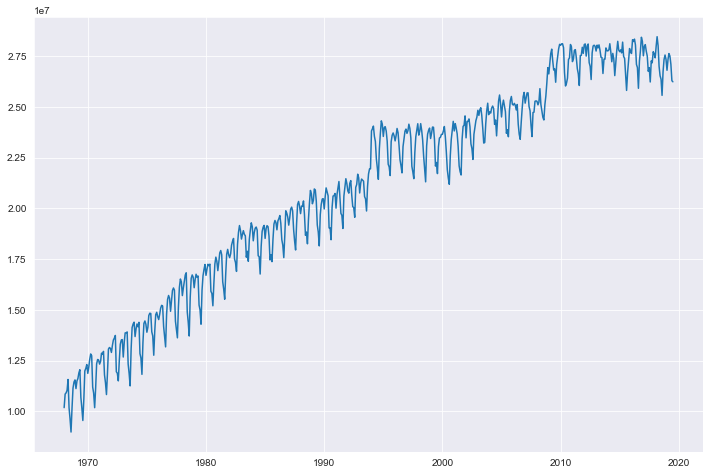

In [190]:
plt.figure(figsize=(12,8))
plt.plot(full_df['Part_time_emp'])

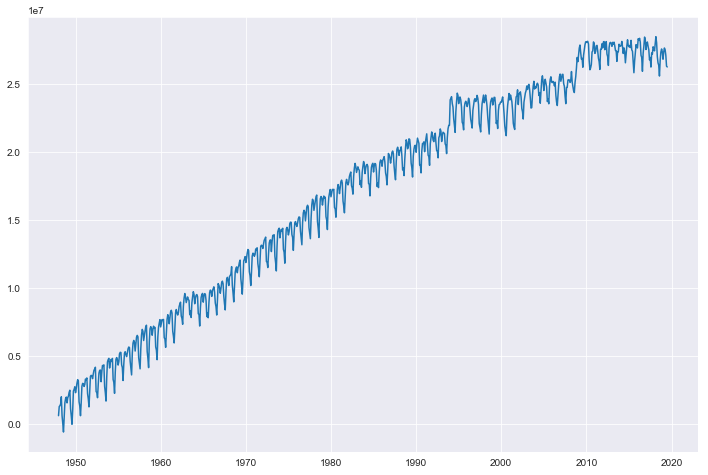

In [191]:
temp_series = full_df['Part_time_emp'] - full_df['Part_time_emp'].shift(-240)
temp_series = temp_series.interpolate(method='time', limit_direction='backward') + full_df['Part_time_emp'].shift(-240)
temp_series = temp_series[temp_series.index.year < 1968]
interpolated_part_time = temp_series.append(full_df[full_df.index.year >= 1968]['Part_time_emp'])

full_df['Part_time_emp'] = interpolated_part_time

plt.figure(figsize=(12,8))
plt.plot(full_df['Part_time_emp'])

In [192]:
full_df['Part_time_%'] = full_df['Part_time_emp'] / full_df['Working_age_pop'] * 100

### SSA Disability

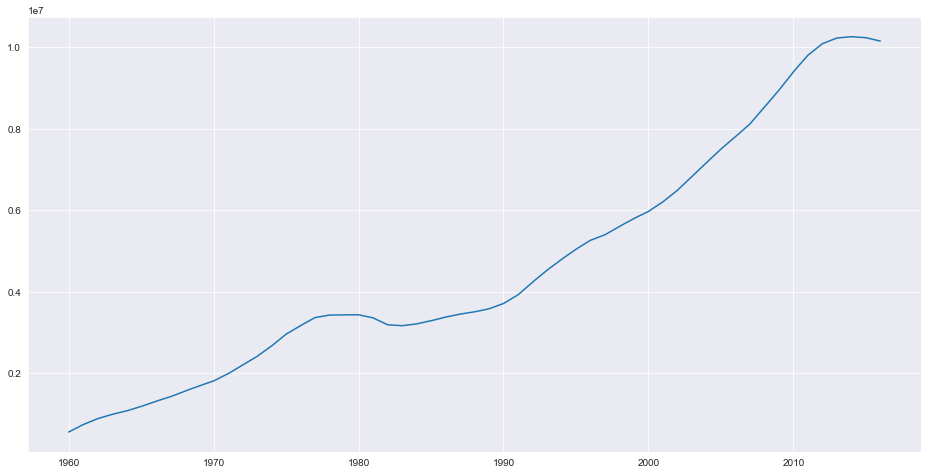

In [193]:
plt.figure(figsize=(16,8))
plt.plot(full_df['SSA_disab'])

In [194]:
backfilled_ssa = full_df[full_df.index.year < 1960]['SSA_disab'].fillna(value=0)
full_df['SSA_disab'] = backfilled_ssa.append(full_df[full_df.index.year >= 1960]['SSA_disab'])

2018-10-01    10307735.0
2018-11-01    10305691.0
2018-12-01    10303713.0
2019-01-01    10301670.0
2019-02-01    10294535.0
2019-03-01    10288092.0
2019-04-01    10280957.0
2019-05-01    10274053.0
2019-06-01    10266919.0
2019-07-01    10260015.0
Name: SSA_disab, dtype: float64

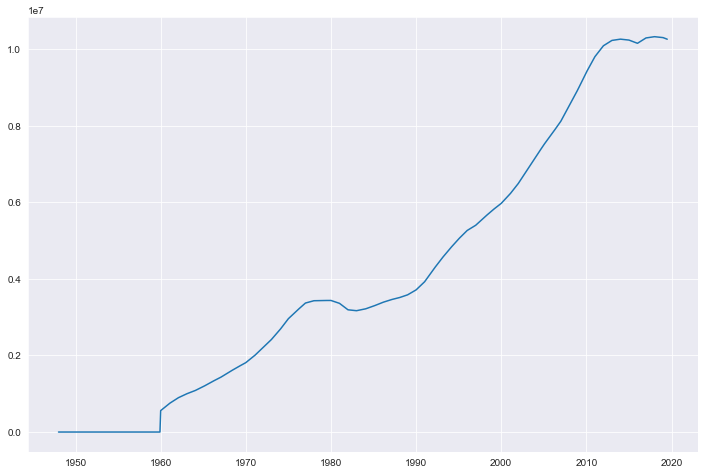

In [195]:
temp_series = full_df['SSA_disab'] - full_df['SSA_disab'].shift(48)
temp_series = temp_series.interpolate(method='time', limit_direction='forward') + full_df['SSA_disab'].shift(48)
temp_series = temp_series[temp_series.index > pd.to_datetime('2016-1-1')]
interpolated_ssa = full_df[full_df.index <= pd.to_datetime('2016-1-1')]['SSA_disab'].append(temp_series)

display(interpolated_ssa.tail(10))
plt.figure(figsize=(12,8))
plt.plot(interpolated_ssa)

In [196]:
full_df['SSA_disab'] = interpolated_ssa

In [197]:
full_df['SSA_disab_%'] = full_df['SSA_disab'] / full_df['Working_age_pop'] * 100

### Reverse Engineering Age 55-64 Workforce

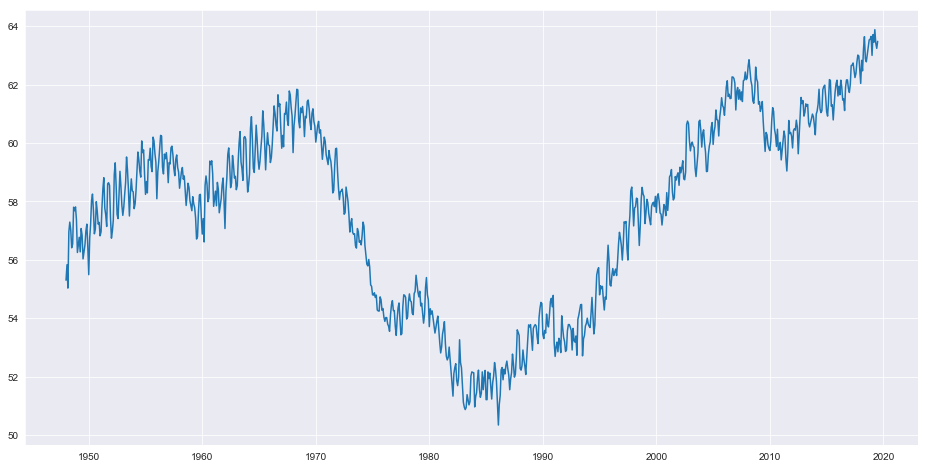

In [198]:
temp_series = full_df['Age_55-64_work_%'] - full_df['Age_55-64_work_%'].shift(-144)
temp_series = temp_series.interpolate(method='time', limit_direction='backward') + full_df['Age_55-64_work_%'].shift(-144)
temp_series = temp_series[temp_series.index.year < 1960]
interpolated_55_64 = temp_series.append(full_df[full_df.index.year >= 1960]['Age_55-64_work_%'])

plt.figure(figsize=(16,8))
plt.plot(interpolated_55_64)

In [199]:
full_df['Age_55-64_work_%'] = interpolated_55_64
full_df['Age_55-64_emp'] = full_df['Age_55-64_pop'] * full_df['Age_55-64_work_%'] * .01

## Full and Part Time Employed

In [200]:
full_and_part_time = pd.read_csv('Season_no/Employees - Full and Part Time no season.csv')
full_and_part_time.columns = ['Date', 'Full_and_part_time']
full_and_part_time['Date'] = pd.to_datetime(full_and_part_time.Date)
full_and_part_time['Full_and_part_time'] = full_and_part_time['Full_and_part_time'] * 1000
full_and_part_time.set_index('Date', inplace=True)
full_and_part_time.head()
full_and_part_time.tail()

,Full_and_part_time
Date,
2014-01-01,143758000.0
2015-01-01,146607000.0
2016-01-01,148734000.0
2017-01-01,150636000.0
2018-01-01,153133000.0


## College Education Levels

In [201]:
education_levels_df = pd.read_csv('US_pop/US_pop_education_levels.csv')
education_levels_df.drop('Median', axis=1, inplace=True)
for col in education_levels_df.columns[1:]:
    education_levels_df[col] = education_levels_df[col].apply(lambda x: int(pretty_data(x))) * 1000
education_levels_df['Date'] = pd.to_datetime(education_levels_df['Year'].astype(str))
education_levels_df.set_index('Date', inplace=True)
education_levels_df.drop(education_levels_df.columns[:-1], axis=1, inplace=True)
education_levels_df.columns = ['College_grads']
education_levels_df.tail()

,College_grads
Date,
1957-01-01,7172000
1952-01-01,6118000
1950-01-01,5272000
1947-01-01,4424000
1940-01-01,3407000


In [202]:
education_levels_df = education_levels_df.resample('MS', how='first').interpolate(method='linear')

In [203]:
education_levels_df.tail()

,College_grads
Date,
2017-09-01,7.598367e+07
2017-10-01,7.621875e+07
2017-11-01,7.645383e+07
2017-12-01,7.668892e+07
2018-01-01,7.692400e+07


## Joining and Interpolating Full Time Workers, Part Time Workers, Education

In [204]:
full_df = full_df.join([education_levels_df, full_and_part_time])

In [205]:
full_df['Full_and_part_time'] = full_df['Full_and_part_time'].interpolate(method='linear')

In [206]:
full_df['Full_time_emp'] = full_df['Full_and_part_time'] - full_df['Part_time_emp']
full_df['Full_time_%'] = full_df['Full_time_emp'] / full_df['Working_age_pop'] * 100

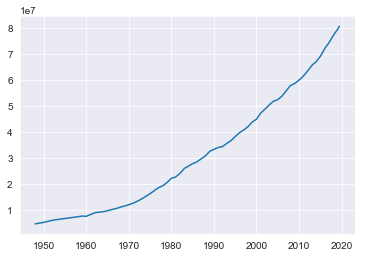

In [207]:
temp_series = full_df['College_grads'] - full_df['College_grads'].shift(24)
temp_series = temp_series.interpolate(method='time', limit_direction='forward') + full_df['College_grads'].shift(24)
temp_series = temp_series[temp_series.index > pd.to_datetime('2018')]
interpolated_college = full_df[full_df.index <= pd.to_datetime('2018')]['College_grads'].append(temp_series)

plt.plot(interpolated_college)

In [208]:
full_df['College_grads'] = interpolated_college

In [209]:
full_df['College_grads_%'] = full_df['College_grads'] / full_df['Working_age_pop'] * 100

In [210]:
full_df['New_Employment_Metric'] = (full_df['Full_time_emp'] + \
                                    full_df['Part_time_emp']*.5 - \
                                    full_df['SSA_disab']) / full_df['Working_age_pop'] * 100

### Moody's Season Baa

In [211]:
moody_df = pd.read_csv('Season_no/Moody Season Baa Bond Minus Fed Funds Rate.csv')
moody_df.columns = ['Date', 'Moodys_Baa']
moody_df['Date'] = pd.to_datetime(moody_df['Date'])
moody_df.set_index('Date', inplace=True)
moody_df.head()

,Moodys_Baa
Date,
1954-07-01,2.70
1954-08-01,2.27
1954-09-01,2.41
1954-10-01,2.61
1954-11-01,2.62


In [213]:
temp_df = full_df.join(moody_df)

temp_series = temp_df['Moodys_Baa'] - temp_df['Moodys_Baa'].shift(-78)
temp_series = temp_series.interpolate(method='time', limit_direction='backward') + temp_df['Moodys_Baa'].shift(-78)
temp_series = temp_series[temp_series.index < pd.to_datetime('1954-7-1')]
interpolated_moody = temp_series.append(temp_df[temp_df.index >= pd.to_datetime('1954-7-1')]['Moodys_Baa'])

full_df['Moodys_Baa'] = interpolated_moody
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 859 entries, 1948-01-01 to 2019-07-01
Freq: MS
Data columns (total 49 columns):
Age_16-19_pop                              859 non-null int64
Age_20-24_pop                              859 non-null int64
Age_25-34_pop                              859 non-null int64
Age_35-44_pop                              859 non-null int64
Age_45-54_pop                              859 non-null int64
Age_55-64_pop                              859 non-null int64
Working_age_pop                            859 non-null int64
Agriculture_emp                            859 non-null float64
Construction_emp                           859 non-null float64
Education_Health_emp                       859 non-null float64
Finance_emp                                859 non-null float64
Leisure_Hospitality_emp                    859 non-null float64
Manufacturing_emp                          859 non-null float64
Professional_emp                           859 no

### Complete Dataframe

In [991]:
full_df.drop('Moodys_Baa(t-12)', axis=1, inplace=True)

In [992]:
full_df.dropna(inplace=True)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 847 entries, 1949-01-01 to 2019-07-01
Freq: MS
Data columns (total 48 columns):
Age_16-19_pop                              847 non-null int64
Age_20-24_pop                              847 non-null int64
Age_25-34_pop                              847 non-null int64
Age_35-44_pop                              847 non-null int64
Age_45-54_pop                              847 non-null int64
Age_55-64_pop                              847 non-null int64
Working_age_pop                            847 non-null int64
Agriculture_emp                            847 non-null float64
Construction_emp                           847 non-null float64
Education_Health_emp                       847 non-null float64
Finance_emp                                847 non-null float64
Leisure_Hospitality_emp                    847 non-null float64
Manufacturing_emp                          847 non-null float64
Professional_emp                           847 no

### DataFrame of only percentage values

In [993]:
model_df = full_df.drop(full_df.columns[:23], axis=1)
model_df.drop(['Age_55-64_emp', 'College_grads', 'Full_and_part_time', 'Full_time_emp'], axis=1, inplace=True)
model_df.drop(['Part_time_%', 'Full_time_%', 'SSA_disab_%'], axis=1, inplace=True)
model_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 847 entries, 1949-01-01 to 2019-07-01
Freq: MS
Data columns (total 18 columns):
Age_16-19_work_%                           847 non-null float64
Age_20-24_work_%                           847 non-null float64
Age_25-34_work_%                           847 non-null float64
Age_35-44_work_%                           847 non-null float64
Age_45-54_work_%                           847 non-null float64
Age_55-64_work_%                           847 non-null float64
Agriculture_%_of_pop                       847 non-null float64
Construction_%_of_pop                      847 non-null float64
Education_Health_%_of_pop                  847 non-null float64
Finance_%_of_pop                           847 non-null float64
Leisure_Hospitality_%_of_pop               847 non-null float64
Manufacturing_%_of_pop                     847 non-null float64
Professional_%_of_pop                      847 non-null float64
Retail_%_of_pop                    

## Analysis

#### Ordering Industries by Growth

In [50]:
industry_change = {}
for industry in industries:
    industry_change.update({industry: full_df['{}_%_of_pop'.format(industry)].iloc[-1] - \
                            full_df['{}_%_of_pop'.format(industry)].iloc[0]})
sort_vals = sorted(industry_change.values())
ordered_industry_list = []
for val in sort_vals:
    for key, value in industry_change.items():
        if val == value:
            ordered_industry_list.append(key)
ordered_industry_list

['Manufacturing',
 'Agriculture',
 'Construction',
 'Finance',
 'Retail',
 'Trade_Transportation_Utilities',
 'Leisure_Hospitality',
 'Professional',
 'Education_Health']

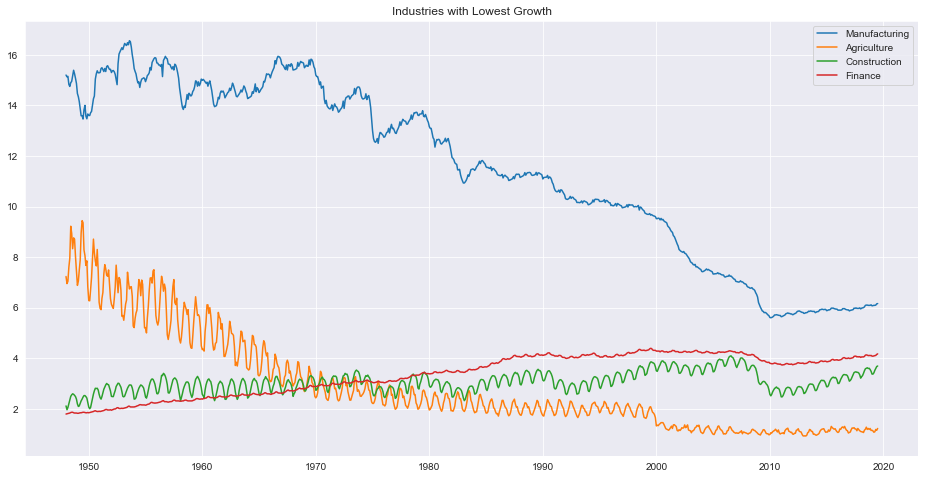

In [51]:
plt.figure(figsize=(16,8))
for industry in ordered_industry_list[:4]:
    plt.plot(full_df['{}_%_of_pop'.format(industry)], label=industry)
plt.legend()
plt.title('Industries with Lowest Growth')
plt.show()

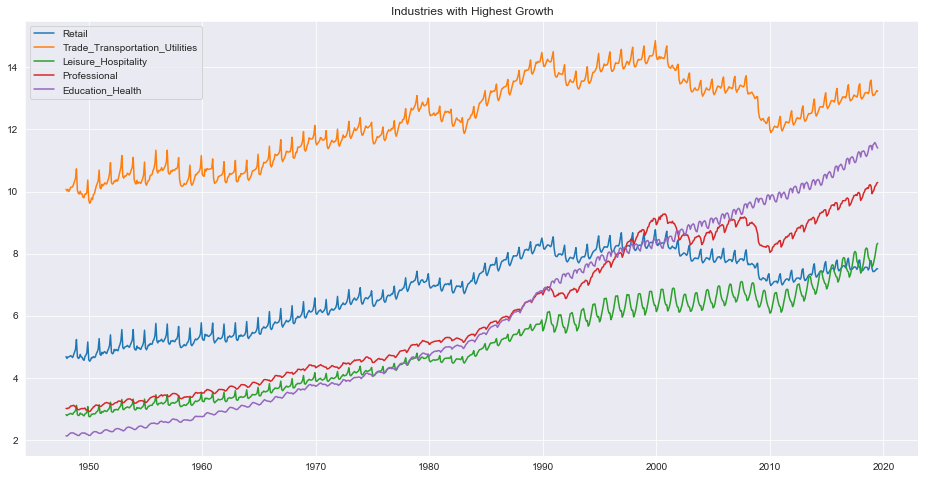

In [52]:
plt.figure(figsize=(16,8))
for industry in ordered_industry_list[4:]:
    plt.plot(full_df['{}_%_of_pop'.format(industry)], label=industry)
plt.legend()
plt.title('Industries with Highest Growth')
plt.show()

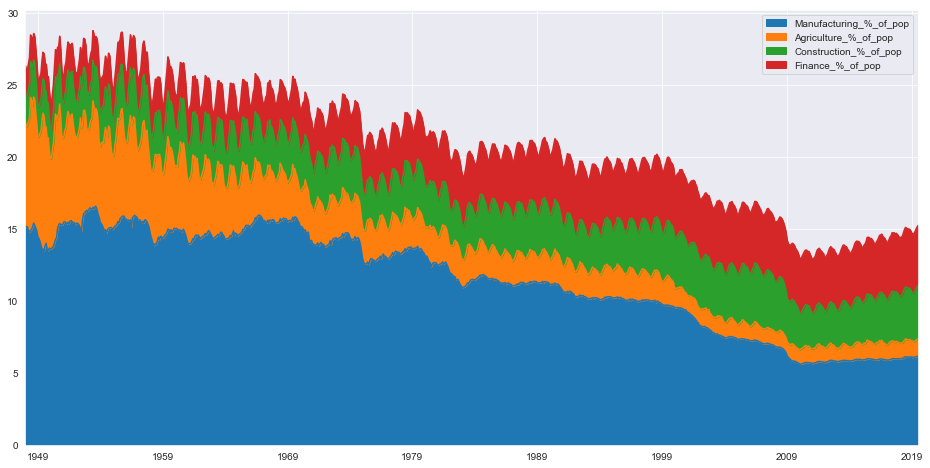

In [53]:
full_df[['{}_%_of_pop'.format(industry) for industry in ordered_industry_list[:4]]].plot.area(figsize=(16,8))

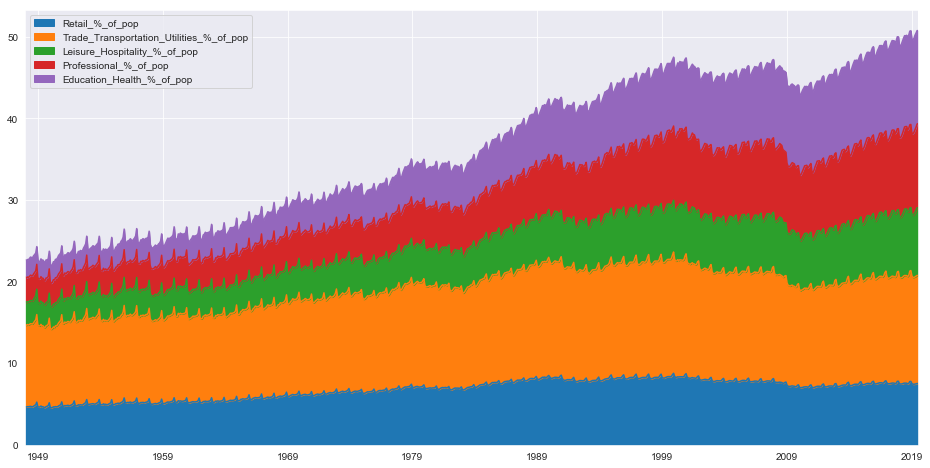

In [54]:
full_df[['{}_%_of_pop'.format(industry) for industry in ordered_industry_list[4:]]].plot.area(figsize=(16,8))

#### Age Groups

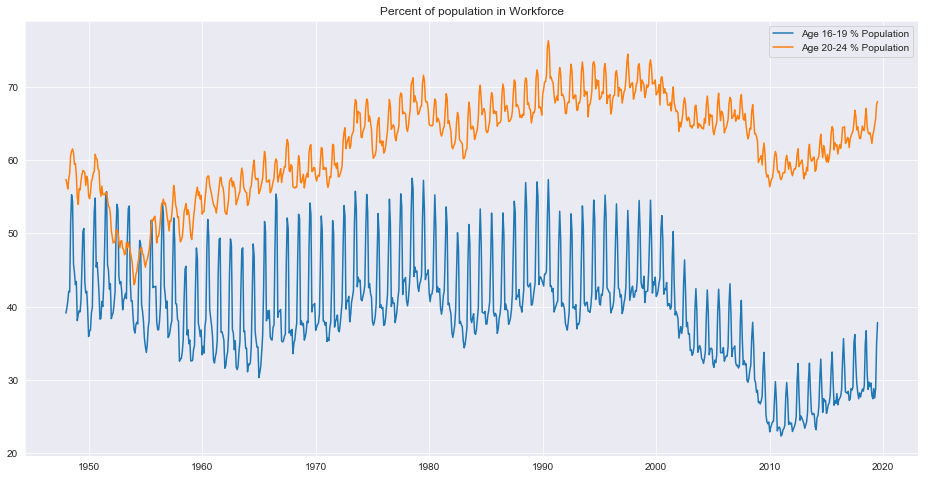

In [55]:
plt.figure(figsize=(16,8))
for age in emp_levels[:2]:
    plt.plot(full_df['Age_{}_work_%'.format(age)], label='Age {} % Population'.format(age))
plt.legend()
plt.title('Percent of population in Workforce')
plt.show()

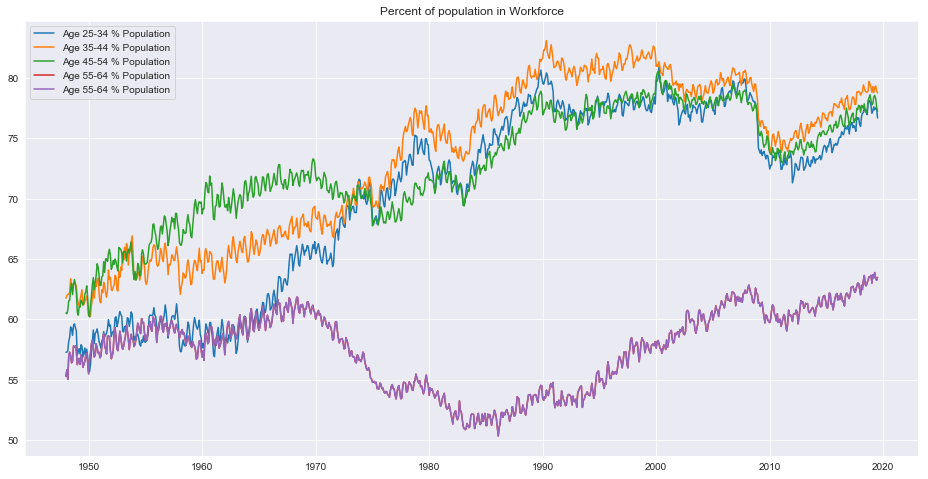

In [56]:
plt.figure(figsize=(16,8))
for age in emp_levels[2:]:
    plt.plot(full_df['Age_{}_work_%'.format(age)], label='Age {} % Population'.format(age))
plt.plot(full_df['Age_55-64_work_%'], label='Age 55-64 % Population')
plt.legend()
plt.title('Percent of population in Workforce')
plt.show()

#### Disability

Text(0.5, 1.0, 'Percent of Workers on Disability as a Percentage of Working Pop')

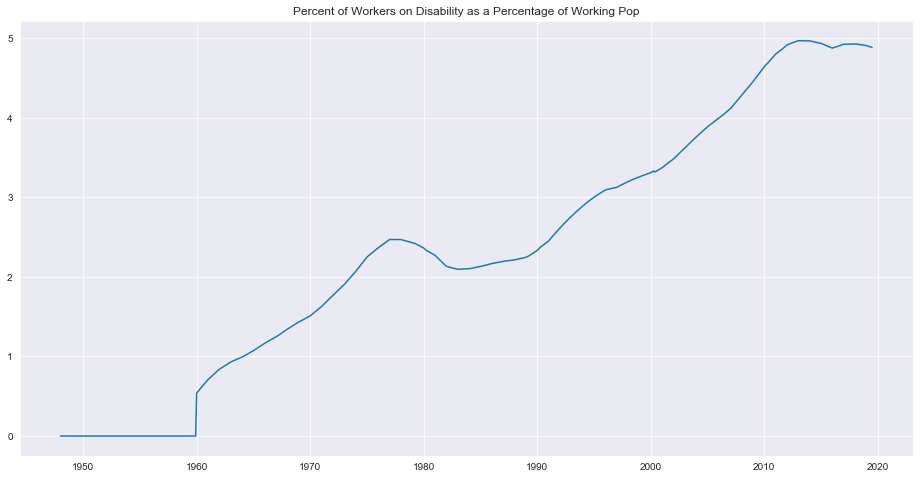

In [57]:
plt.figure(figsize=(16,8))
plt.plot(full_df['SSA_disab_%'])
plt.title('Percent of Workers on Disability as a Percentage of Working Pop')

#### Full Time and Part Time Workers

Text(0.5, 1.0, 'Full Time Workers as a Percentage of Working Pop')

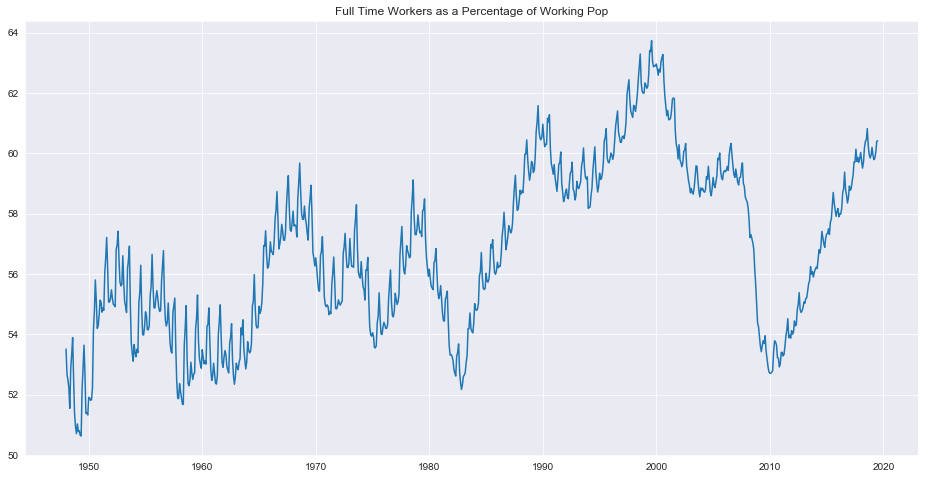

In [58]:
plt.figure(figsize=(16,8))
plt.plot(full_df['Full_time_%'])
plt.title('Full Time Workers as a Percentage of Working Pop')

Text(0.5, 1.0, 'Part Time Workers as a Percentage of Working Pop')

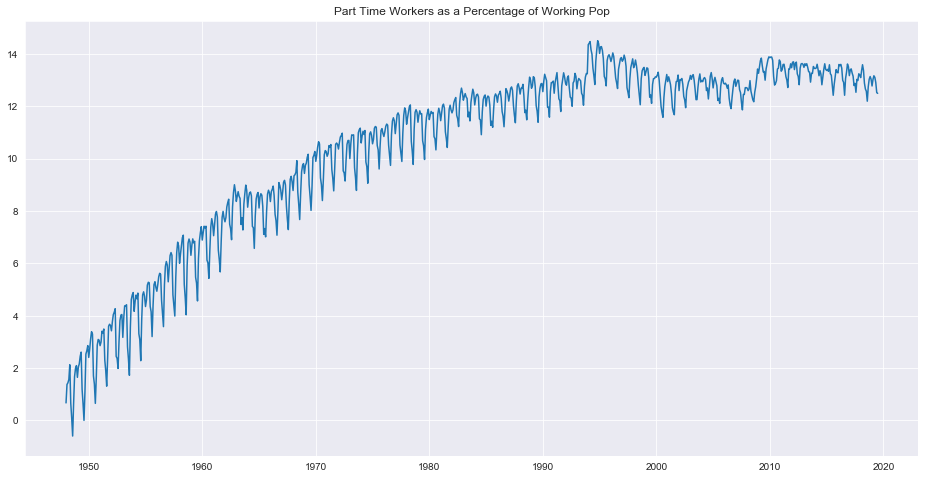

In [59]:
plt.figure(figsize=(16,8))
plt.plot(full_df['Part_time_%'])
plt.title('Part Time Workers as a Percentage of Working Pop')

Text(0.5, 1.0, 'Part Time Workers as a Percentage of Working Pop')

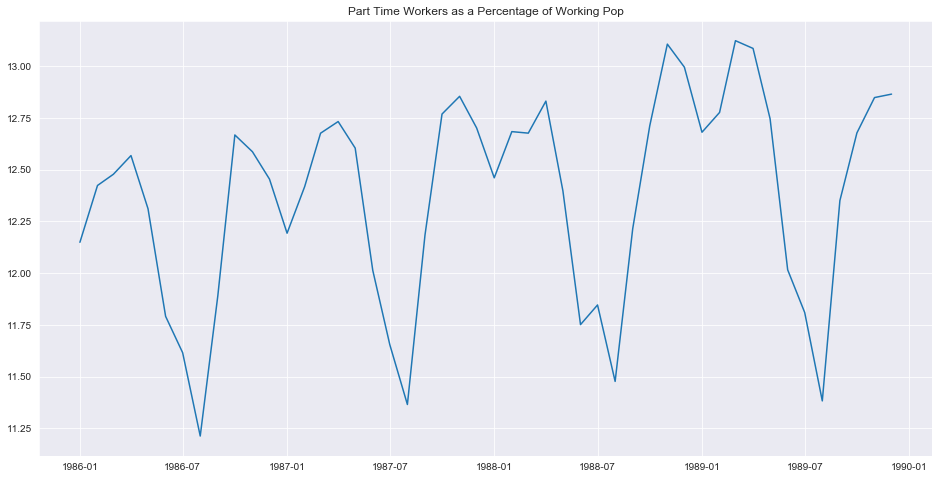

In [60]:
plt.figure(figsize=(16,8))
plt.plot(full_df[(full_df.index.year > 1985) & (full_df.index.year < 1990)]['Part_time_%'])
plt.title('Part Time Workers as a Percentage of Working Pop')

#### Education

Text(0.5, 1.0, 'College grads as a Percentage of Working Population')

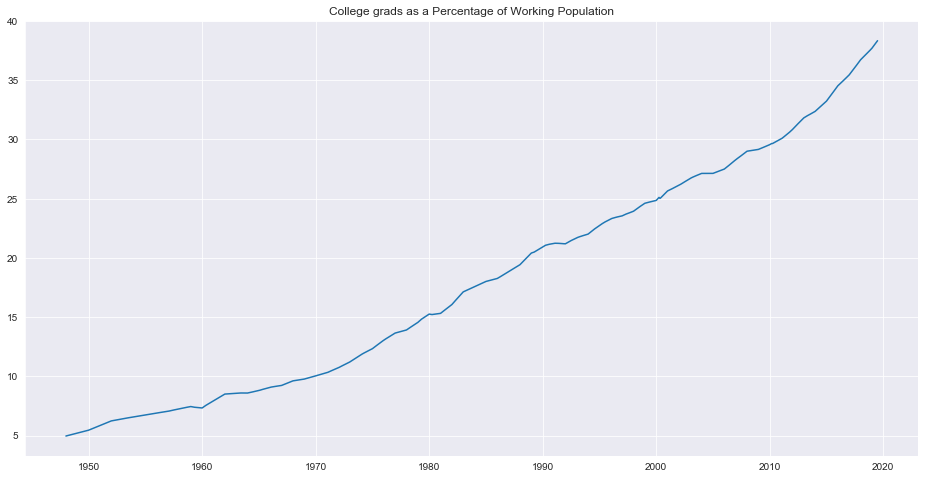

In [61]:
plt.figure(figsize=(16,8))
plt.plot(full_df['College_grads_%'])
plt.title('College grads as a Percentage of Working Population')

#### New Employment Metric

Text(0.5, 1.0, 'New Employment Metric (Full Time + Part Time * 0.5 - Disability)')

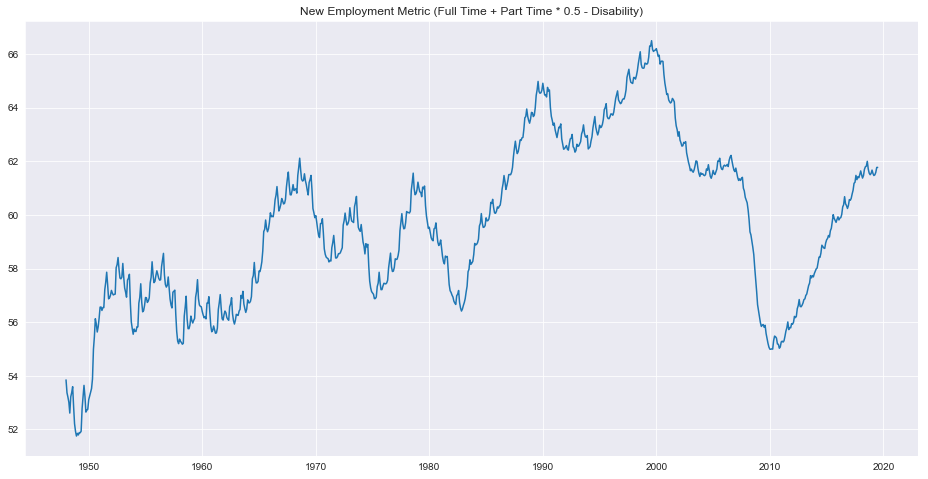

In [62]:
plt.figure(figsize=(16,8))
plt.plot(full_df['New_Employment_Metric'])
plt.title('New Employment Metric (Full Time + Part Time * 0.5 - Disability)')

## Baseline Model Building

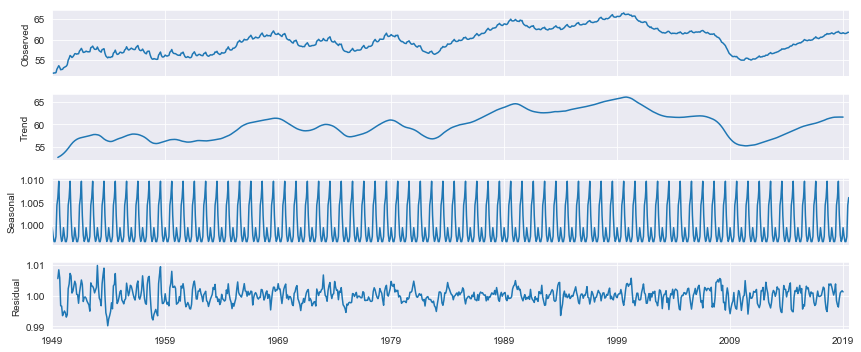

In [257]:
rcParams['figure.figsize'] = 12, 5
seasonal_decompose(model_df['New_Employment_Metric'], model='multiplicative').plot()
plt.show()

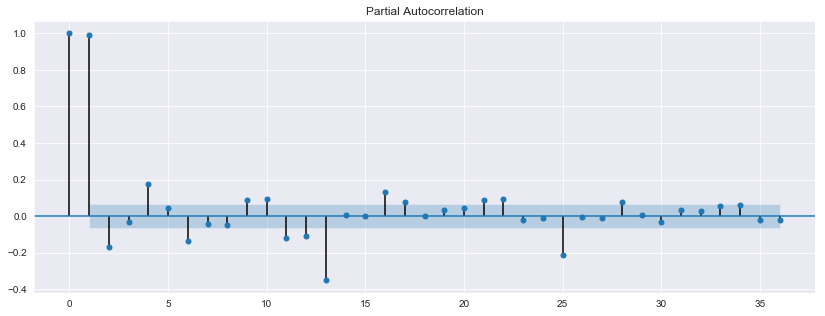

In [248]:
rcParams['figure.figsize'] = 14, 5
plot_pacf(model_df['New_Employment_Metric'], lags=36)
plt.show()

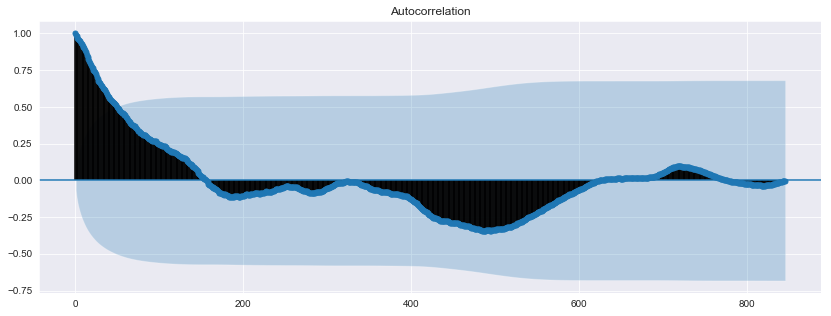

In [249]:
plot_acf(model_df['New_Employment_Metric'])
plt.show()

In [393]:
def scale_data(df, train_size=0, test_size=0):
    scaler = MinMaxScaler()
    
    if train_size==0 and test_size==0:
        if type(df) == pd.core.series.Series:
            values = scaler.fit_transform(df.values.reshape(-1,1))
        else:
            values = scaler.fit_transform(df)
        return scaler, values
    
    else:
        if type(df) == pd.core.series.Series:
            train_df = df.iloc[:train_size]
            test_df = df.iloc[train_size:(train_size+test_size)]
            train_values = scaler.fit_transform(train_df.values.reshape(-1,1))
            test_values = scaler.transform(test_df.values.reshape(-1,1))
        else:
            train_df = df.iloc[:train_size, :]
            test_df = df.iloc[train_size:(train_size+test_size), :]
            train_values = scaler.fit_transform(train_df.values)
            test_values = scaler.transform(test_df.values)
            
            # lstm_train = model_df.iloc[:-(n_steps_in+n_steps_out+11), :]
            # lstm_test = model_df.iloc[-(n_steps_in+n_steps_out+11):, :]
    
        return scaler, train_values, test_values

In [ ]:
help(pm.auto_arima)

In [292]:
auto_arima_scaler, data = scale_data(model_df['New_Employment_Metric'])
# exog = model_df.drop('New_Employment_Metric', axis=1)
stepwise_model = pm.auto_arima(data, start_p=0, start_q=0,
                               max_p=6, max_q=6, m=12,
                               start_P=1, start_Q=1,
                               max_P=6, max_Q=6,
                               seasonal=True, trace=True,
                               error_action='ignore',
                               n_jobs=-1, suppress_warnings=True, 
                               stepwise=True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 12); AIC=-5335.391, BIC=-5316.429, Fit time=0.496 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=-4381.903, BIC=-4372.422, Fit time=0.127 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=-5406.693, BIC=-5387.731, Fit time=1.666 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=-4902.043, BIC=-4883.081, Fit time=2.192 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=-4453.575, BIC=-4439.353, Fit time=0.112 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 0, 12); AIC=-5485.211, BIC=-5461.508, Fit time=6.454 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 1, 12); AIC=-5551.182, BIC=-5522.739, Fit time=6.433 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 0, 2, 12); AIC=-5579.862, BIC=-5541.938, Fit time=43.050 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(3, 0, 2, 12); AIC=-5422.543, BIC=-5389.359, Fit time=27.017 seconds
Fit ARIM

In [293]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  847
Model:             SARIMAX(4, 1, 0)x(3, 0, 3, 12)   Log Likelihood                2860.908
Date:                            Tue, 10 Sep 2019   AIC                          -5697.816
Time:                                    13:25:28   BIC                          -5640.930
Sample:                                         0   HQIC                         -5676.021
                                            - 847                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.232e-05      0.000      0.107      0.915      -0.000       0.000
ar.L1          0.2504      0.028      8.953      0.000       0.196       0.305
ar.L2          0.2204      0.036      6.154      0.000       0.150       0.291
ar.L3          0.2071      0.032      6.466      0.000       0.144       0.270
ar.L4          0.1013      0.035      2.928      0.003       0.034       0.169
ar.S.L12       0.5307      0.718      0.739      0.460      -0.877       1.938
ar.S.L24       0.0609      0.482      0.126      0.899      -0.884       1.005
ar.S.L36       0.3641      0.522      0.698      0.485      -0.659       1.387
ma.S.L12      -0.1939      0.722     -0.269      0.788      -1.609       1.221
ma.S.L24       0.0150      0.378      0.040      0.968      -0.726       0.756
ma.S.L36      -0.2077      0.389     -0.534      0.593      -0.970       0.554
sigma2      6.516e-05   2.21e-06     29.480      0.000    6.08e-05    6.95e-05
===================================================================================
Ljung-Box (Q):                       87.86   Jarque-Bera (JB):               423.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [439]:
config = [(4,1,0), (3,0,3,12)]

In [982]:
n_steps_in = 12
n_steps_out = 12*4
n_features = len(model_df.columns)

In [441]:
# base_df = model_df.applymap(lambda x: x/100)

In [442]:
# base_train = base_df.iloc[:-(n_steps_in+n_steps_out+11), :]
# base_test = base_df.iloc[-(n_steps_in+n_steps_out+11):, :]

# scaler = MinMaxScaler()
# base_train = scaler.fit_transform(base_train.values)
# base_test = scaler.transform(base_test.values)

In [443]:
# tscv = TimeSeriesSplit(n_splits=5)
# tscv.split()

In [444]:
def sarima_forecast(history, config):
    order, sorder = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, 
                    enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [445]:
# walk-forward validation for univariate data
def walk_forward_validation(df, n_steps_in_mult, n_steps_out, cfg):
    predictions = list()
    # split dataset
    scaler, train, test = scale_data(df, n_steps_in_mult, n_steps_out)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        predictions.append(yhat)

        history.append(yhat.reshape(1,))
    # estimate prediction error
    error = np.sqrt(mean_squared_error(test.reshape(1,-1)[0], predictions))
    return error

In [423]:
errors = []
for n_test in tqdm(range(3, len(model_df) // n_steps_in)):
    print('Train size', n_test*n_steps_in)
    errors.append(walk_forward_validation(model_df['New_Employment_Metric'], 
                                          (n_steps_in*n_test), n_steps_out, config))
print(errors)                      












  0%|          | 0/8 [00:00<?, ?it/s]

Train size 216













 12%|█▎        | 1/8 [01:47<12:32, 107.46s/it]

Train size 288













 25%|██▌       | 2/8 [03:54<11:20, 113.36s/it]

Train size 360













 38%|███▊      | 3/8 [06:07<09:55, 119.10s/it]

Train size 432













 50%|█████     | 4/8 [08:44<08:42, 130.62s/it]

Train size 504













 62%|██████▎   | 5/8 [11:47<07:18, 146.19s/it]

Train size 576













 75%|███████▌  | 6/8 [15:08<05:25, 162.69s/it]

Train size 648













 88%|████████▊ | 7/8 [18:43<02:58, 178.54s/it]

Train size 720













100%|██████████| 8/8 [21:37<00:00, 176.95s/it]

[0.007185199545585351, 0.06380354428884748, 0.11182785085452118, 0.02506921248400942, 0.01317552839646631, 0.03460950029622324, 0.007906033443878068, 0.052803505228365674]


In [424]:
walk_forward_rmse = sum(errors) / len(errors)
walk_forward_rmse

0.03954754681723709

In [983]:
arima_scaler, scaled_series = scale_data(model_df['New_Employment_Metric'])
short_history = [x for x in scaled_series[:-n_steps_out]]
predictions = []
for i in tqdm(range(n_steps_out)):
    yhat = sarima_forecast(short_history, config)
    predictions.append(yhat)
    short_history.append(yhat.reshape(1,))













  0%|          | 0/48 [00:00<?, ?it/s]











  2%|▏         | 1/48 [00:19<15:34, 19.87s/it]











  4%|▍         | 2/48 [00:39<15:04, 19.67s/it]











  6%|▋         | 3/48 [00:55<14:06, 18.82s/it]











  8%|▊         | 4/48 [01:16<14:08, 19.29s/it]











 10%|█         | 5/48 [01:34<13:30, 18.85s/it]











 12%|█▎        | 6/48 [01:54<13:25, 19.19s/it]











 15%|█▍        | 7/48 [02:13<13:03, 19.11s/it]











 17%|█▋        | 8/48 [02:44<15:17, 22.95s/it]











 19%|█▉        | 9/48 [03:08<15:03, 23.17s/it]











 21%|██        | 10/48 [03:25<13:27, 21.25s/it]











 23%|██▎       | 11/48 [03:44<12:40, 20.54s/it]











 25%|██▌       | 12/48 [04:03<12:07, 20.21s/it]











 27%|██▋       | 13/48 [04:19<10:57, 18.77s/it]











 29%|██▉       | 14/48 [04:35<10:12, 18.02s/it]











 31%|███▏      | 15/48 [04:56<10:20, 18.80s/it]











 33%|███▎      | 16/48 [05:15<10:04, 18.88s/it]











 35

RMSE: 0.8925724165764061


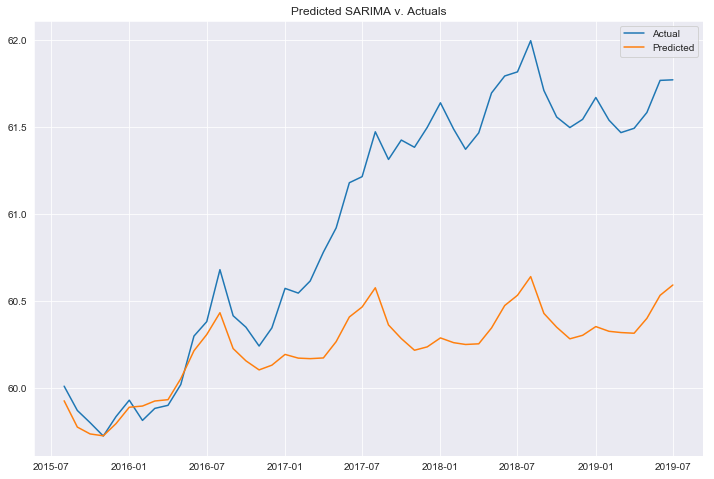

In [984]:
inversed_arima_pred = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
arima_pred_series = pd.Series(inversed_arima_pred.reshape(n_steps_out,), index=model_df.iloc[-n_steps_out:].index)

error = np.sqrt(mean_squared_error(model_df['New_Employment_Metric'].iloc[-n_steps_out:].values, 
                                   arima_pred_series.values))

print('RMSE:', error)
plt.figure(figsize=(12,8))
plt.plot(model_df['New_Employment_Metric'].iloc[-n_steps_out:], label='Actual')
plt.plot(arima_pred_series, label='Predicted')
plt.legend()
plt.title('Predicted SARIMA v. Actuals')
plt.show()

## Neural Network Model Building

In [969]:
n_steps_in = 12
n_steps_out = 12*4
n_features = len(model_df.columns)

In [970]:
shift_df = model_df[model_df.columns.shift(1)
lstm_df = model_df[model_df.columns.diff(1).dropna()

# for col in lstm_df.columns:
#     lstm_df[col+'(t-6)'] = lstm_df[col].shift(6)
#     lstm_df[col+'(t-12)'] = lstm_df[col].shift(12)
# lstm_df.dropna(inplace=True)

In [971]:
lstm_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 846 entries, 1949-02-01 to 2019-07-01
Freq: MS
Data columns (total 18 columns):
Age_16-19_work_%                           846 non-null float64
Age_20-24_work_%                           846 non-null float64
Age_25-34_work_%                           846 non-null float64
Age_35-44_work_%                           846 non-null float64
Age_45-54_work_%                           846 non-null float64
Age_55-64_work_%                           846 non-null float64
Agriculture_%_of_pop                       846 non-null float64
Construction_%_of_pop                      846 non-null float64
Education_Health_%_of_pop                  846 non-null float64
Finance_%_of_pop                           846 non-null float64
Leisure_Hospitality_%_of_pop               846 non-null float64
Manufacturing_%_of_pop                     846 non-null float64
Professional_%_of_pop                      846 non-null float64
Retail_%_of_pop                    

In [972]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [973]:
lstm_scaler, lstm_train, lstm_test = scale_data(lstm_df, 
                                                (len(lstm_df) - (n_steps_in+n_steps_out)), 
                                                (n_steps_in+n_steps_out))

train_X, train_y = split_sequences(lstm_train, n_steps_in, n_steps_out)
test_X, test_y = split_sequences(lstm_test, n_steps_in, n_steps_out)
print('Train', train_X.shape, train_y.shape)
print('Test', test_X.shape, test_y.shape)

Train (727, 12, 18) (727, 48, 18)
Test (1, 12, 18) (1, 48, 18)


In [974]:
warnings.filterwarnings('ignore')
nn_model = Sequential()
nn_model.add(LSTM(60, activation='tanh', kernel_initializer='lecun_normal',
                  input_shape=(train_X.shape[1], train_X.shape[2])))
nn_model.add(RepeatVector(n_steps_out))
nn_model.add(SimpleRNN(60, activation='tanh', kernel_initializer='lecun_normal',
                  return_sequences=True))
nn_model.add(TimeDistributed(Dense(train_X.shape[2])))
nn_model.add(advanced_activations.LeakyReLU())
nn_model.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [975]:
warnings.filterwarnings('ignore')
hist = nn_model.fit(train_X, train_y, batch_size=32, epochs=300, validation_data=(test_X, test_y),
                    callbacks=[EarlyStopping(monitor='loss', patience=20)])

Train on 727 samples, validate on 1 samples
Epoch 1/300
727/727 [==============================] - 17s 24ms/step - loss: 0.1165 - acc: 0.0986 - val_loss: 0.0429 - val_acc: 0.0625
Epoch 2/300
727/727 [==============================] - 1s 874us/step - loss: 0.0310 - acc: 0.1344 - val_loss: 0.0341 - val_acc: 0.1458
Epoch 3/300
727/727 [==============================] - 1s 808us/step - loss: 0.0248 - acc: 0.1880 - val_loss: 0.0298 - val_acc: 0.0417
Epoch 4/300
727/727 [==============================] - 1s 837us/step - loss: 0.0231 - acc: 0.1869 - val_loss: 0.0280 - val_acc: 0.7083
Epoch 5/300
727/727 [==============================] - 1s 934us/step - loss: 0.0222 - acc: 0.1956 - val_loss: 0.0265 - val_acc: 0.7708
Epoch 6/300
727/727 [==============================] - 1s 905us/step - loss: 0.0216 - acc: 0.2087 - val_loss: 0.0261 - val_acc: 0.7292
Epoch 7/300
727/727 [==============================] - 1s 1ms/step - loss: 0.0212 - acc: 0.2248 - val_loss: 0.0257 - val_acc: 0.7500
Epoch 8/300
7

727/727 [==============================] - 1s 1ms/step - loss: 0.0200 - acc: 0.2587 - val_loss: 0.0225 - val_acc: 0.8542
Epoch 62/300
727/727 [==============================] - 1s 1ms/step - loss: 0.0200 - acc: 0.2715 - val_loss: 0.0229 - val_acc: 0.8542
Epoch 63/300
727/727 [==============================] - 1s 961us/step - loss: 0.0200 - acc: 0.2743 - val_loss: 0.0231 - val_acc: 0.8542
Epoch 64/300
727/727 [==============================] - 1s 1ms/step - loss: 0.0199 - acc: 0.2759 - val_loss: 0.0226 - val_acc: 0.8542
Epoch 65/300
727/727 [==============================] - 1s 1ms/step - loss: 0.0200 - acc: 0.2659 - val_loss: 0.0222 - val_acc: 0.8542
Epoch 66/300
727/727 [==============================] - 1s 1ms/step - loss: 0.0200 - acc: 0.2731 - val_loss: 0.0232 - val_acc: 0.8542
Epoch 67/300
727/727 [==============================] - 1s 980us/step - loss: 0.0199 - acc: 0.2784 - val_loss: 0.0226 - val_acc: 0.8542
Epoch 68/300
727/727 [==============================] - 1s 1ms/step - l

727/727 [==============================] - 1s 839us/step - loss: 0.0125 - acc: 0.3037 - val_loss: 0.0153 - val_acc: 0.6458
Epoch 122/300
727/727 [==============================] - 1s 942us/step - loss: 0.0111 - acc: 0.3171 - val_loss: 0.0162 - val_acc: 0.5208
Epoch 123/300
727/727 [==============================] - 1s 923us/step - loss: 0.0105 - acc: 0.3375 - val_loss: 0.0160 - val_acc: 0.5833
Epoch 124/300
727/727 [==============================] - 1s 887us/step - loss: 0.0100 - acc: 0.3504 - val_loss: 0.0156 - val_acc: 0.6667
Epoch 125/300
727/727 [==============================] - 1s 1ms/step - loss: 0.0096 - acc: 0.3564 - val_loss: 0.0163 - val_acc: 0.3542
Epoch 126/300
727/727 [==============================] - 1s 1ms/step - loss: 0.0094 - acc: 0.3583 - val_loss: 0.0158 - val_acc: 0.4375
Epoch 127/300
727/727 [==============================] - 1s 1ms/step - loss: 0.0092 - acc: 0.3596 - val_loss: 0.0148 - val_acc: 0.5625
Epoch 128/300
727/727 [==============================] - 1s 1

727/727 [==============================] - 1s 994us/step - loss: 0.0059 - acc: 0.5170 - val_loss: 0.0120 - val_acc: 0.2292
Epoch 182/300
727/727 [==============================] - 1s 803us/step - loss: 0.0058 - acc: 0.5203 - val_loss: 0.0114 - val_acc: 0.2500
Epoch 183/300
727/727 [==============================] - 1s 961us/step - loss: 0.0059 - acc: 0.5222 - val_loss: 0.0122 - val_acc: 0.2292
Epoch 184/300
727/727 [==============================] - 1s 1ms/step - loss: 0.0058 - acc: 0.5191 - val_loss: 0.0121 - val_acc: 0.2083
Epoch 185/300
727/727 [==============================] - 1s 936us/step - loss: 0.0058 - acc: 0.5231 - val_loss: 0.0128 - val_acc: 0.2292
Epoch 186/300
727/727 [==============================] - 1s 898us/step - loss: 0.0058 - acc: 0.5205 - val_loss: 0.0130 - val_acc: 0.2292
Epoch 187/300
727/727 [==============================] - 1s 877us/step - loss: 0.0058 - acc: 0.5235 - val_loss: 0.0125 - val_acc: 0.2083
Epoch 188/300
727/727 [==============================] - 

727/727 [==============================] - 1s 878us/step - loss: 0.0052 - acc: 0.5644 - val_loss: 0.0145 - val_acc: 0.2292
Epoch 242/300
727/727 [==============================] - 1s 844us/step - loss: 0.0052 - acc: 0.5601 - val_loss: 0.0136 - val_acc: 0.2083
Epoch 243/300
727/727 [==============================] - 1s 1ms/step - loss: 0.0052 - acc: 0.5585 - val_loss: 0.0120 - val_acc: 0.2500
Epoch 244/300
727/727 [==============================] - 1s 1ms/step - loss: 0.0052 - acc: 0.5630 - val_loss: 0.0136 - val_acc: 0.2500
Epoch 245/300
727/727 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 0.5641 - val_loss: 0.0122 - val_acc: 0.2500
Epoch 246/300
727/727 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 0.5630 - val_loss: 0.0128 - val_acc: 0.2292
Epoch 247/300
727/727 [==============================] - 1s 991us/step - loss: 0.0051 - acc: 0.5679 - val_loss: 0.0142 - val_acc: 0.2292
Epoch 248/300
727/727 [==============================] - 1s 895

In [976]:
# train_predict = nn_model.predict(train_X)
# test_predict = nn_model.predict(test_X)

# train_rmse = np.sqrt(sum([mean_squared_error(train_y[0], train_predict[0]) 
#                           for i in range(len(train_predict))]) / len(train_predict))
# test_rmse = np.sqrt(sum([mean_squared_error(test_y[0], test_predict[0]) 
#                          for i in range(len(test_predict))]) / len(test_predict))

# print('Train Root Mean Squared Error:', train_rmse)
# print('Test Root Mean Squared Error:', test_rmse)

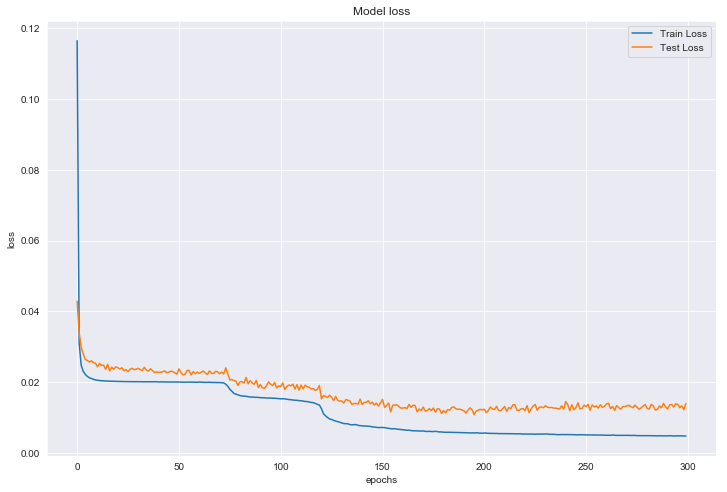

In [977]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Test Loss')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

RMSE: 4.19318430206587


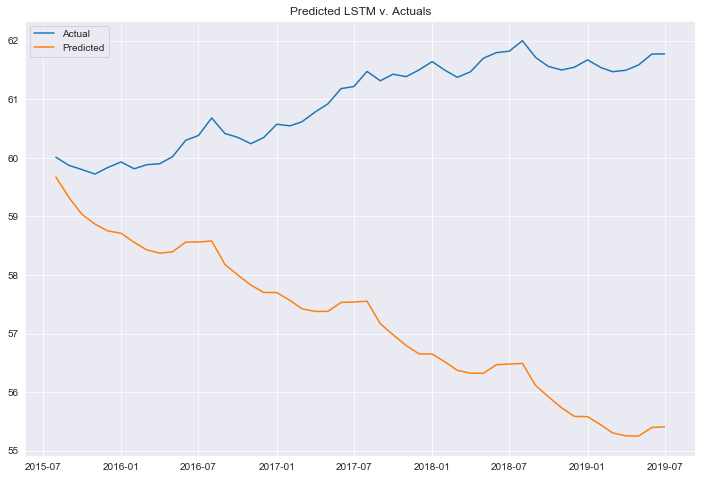

In [1028]:
lstm_predictions = nn_model.predict(test_X)

inversed_lstm_pred = lstm_scaler.inverse_transform(lstm_predictions.reshape(n_steps_out, len(lstm_df.columns)))

lstm_pred_df = pd.DataFrame((model_df.iloc[-(n_steps_out+1)].values+inversed_lstm_pred[0]).reshape(1,-1))

for i in range(1, n_steps_out):
    temp_df = pd.DataFrame(lstm_pred_df.iloc[i-1].values+inversed_lstm_pred[i].reshape(1,-1))
    lstm_pred_df = lstm_pred_df.append(temp_df)

lstm_pred_df.columns = model_df.columns
lstm_pred_df.set_index(model_df.iloc[-n_steps_out:].index, inplace=True)

error = np.sqrt(mean_squared_error(model_df['New_Employment_Metric'].iloc[-n_steps_out:].values, 
                                   lstm_pred_df['New_Employment_Metric'].values))

print('RMSE:', error)
plt.figure(figsize=(12,8))
plt.plot(model_df['New_Employment_Metric'].iloc[-n_steps_out:], label='Actual')
plt.plot(lstm_pred_df['New_Employment_Metric'], label='Predicted')
plt.legend()
plt.title('Predicted LSTM v. Actuals')
plt.show()

In [979]:
scaled_df = lstm_scaler.transform(lstm_df.values)
lstm_full_X, lstm_full_y = split_sequences(scaled_df, n_steps_in, n_steps_out)
full_model_predict = nn_model.predict(lstm_full_X)
full_model_predict.shape

(787, 48, 18)

In [980]:
pred_data = [full_model_predict[i][0] for i in range(len(full_model_predict))]
for j in range(1,n_steps_out):
    pred_data.append(full_model_predict[len(full_model_predict)-1][j])
re_scaled = lstm_scaler.inverse_transform(pred_data)
predict_df = pd.DataFrame(re_scaled, columns=lstm_df.columns)
predict_df.set_index(lstm_df.iloc[n_steps_in:].index, inplace=True)
predict_df = (predict_df + predict_df.shift(1)).dropna()

display(predict_df.head())
display(predict_df.tail())

,Age_16-19_work_%,Age_20-24_work_%,Age_25-34_work_%,Age_35-44_work_%,Age_45-54_work_%,Age_55-64_work_%,Agriculture_%_of_pop,Construction_%_of_pop,Education_Health_%_of_pop,Finance_%_of_pop,Leisure_Hospitality_%_of_pop,Manufacturing_%_of_pop,Professional_%_of_pop,Retail_%_of_pop,Trade_Transportation_Utilities_%_of_pop,College_grads_%,New_Employment_Metric,Moodys_Baa
1950-02-01,35.834763,55.125547,55.588673,60.392333,60.339002,55.432259,6.294296,2.042923,2.151414,1.847507,2.686409,13.564927,2.912835,4.413189,9.528739,5.482813,53.112047,0.014353
1950-03-01,35.167704,54.716374,56.060711,60.855501,60.732775,57.066089,6.329388,2.069749,2.174689,1.860432,2.779391,13.608559,2.932015,4.602232,9.694781,5.509584,53.238586,0.174021
1950-04-01,35.981142,55.246223,56.775935,60.894922,61.811507,57.647575,6.897862,2.181592,2.186236,1.872576,2.854880,13.708170,2.968123,4.716507,9.828548,5.537573,53.409759,0.124228
1950-05-01,41.148184,57.123219,57.510665,61.429528,62.245593,58.124098,7.510428,2.385303,2.215343,1.884975,2.865356,13.800507,3.000716,4.689440,9.839282,5.571540,53.781461,0.089531
1950-06-01,45.159882,58.728130,58.053318,61.551085,62.767489,58.089503,8.222494,2.555614,2.232961,1.912069,2.866452,14.071996,3.046520,4.713610,9.845607,5.612566,54.220323,0.231244


,Age_16-19_work_%,Age_20-24_work_%,Age_25-34_work_%,Age_35-44_work_%,Age_45-54_work_%,Age_55-64_work_%,Agriculture_%_of_pop,Construction_%_of_pop,Education_Health_%_of_pop,Finance_%_of_pop,Leisure_Hospitality_%_of_pop,Manufacturing_%_of_pop,Professional_%_of_pop,Retail_%_of_pop,Trade_Transportation_Utilities_%_of_pop,College_grads_%,New_Employment_Metric,Moodys_Baa
2019-03-01,27.342873,63.579925,77.522165,79.582767,78.084988,63.984993,1.138966,3.392494,11.540978,4.083503,7.722759,6.068792,10.021292,7.410426,13.065090,37.837974,61.401332,2.452237
2019-04-01,29.063061,63.959506,77.929048,79.070524,78.506492,63.460582,1.155595,3.507342,11.529874,4.089689,7.890688,6.086599,10.107927,7.439969,13.108220,37.943957,61.419808,2.443981
2019-05-01,27.799809,64.235439,77.483734,79.409604,78.711493,63.772620,1.098969,3.600008,11.530587,4.102796,8.048347,6.086452,10.152733,7.464106,13.143984,38.040141,61.490457,2.171085
2019-06-01,33.834101,67.520511,77.395132,78.939290,77.924989,62.960714,1.221850,3.660423,11.417986,4.135579,8.269279,6.117691,10.243122,7.494979,13.203917,38.157052,61.730221,2.123866
2019-07-01,38.354112,68.081546,77.255051,78.653162,77.316733,62.812429,1.125019,3.690306,11.372944,4.153157,8.315691,6.036613,10.239907,7.472480,13.159257,38.266501,61.780496,1.887860


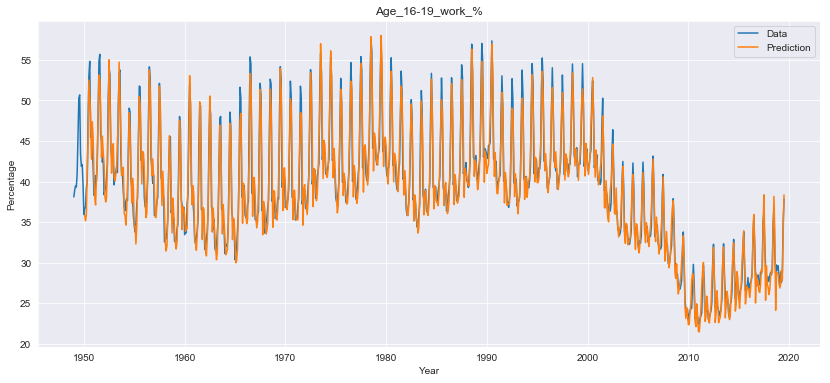

<Figure size 432x288 with 0 Axes>

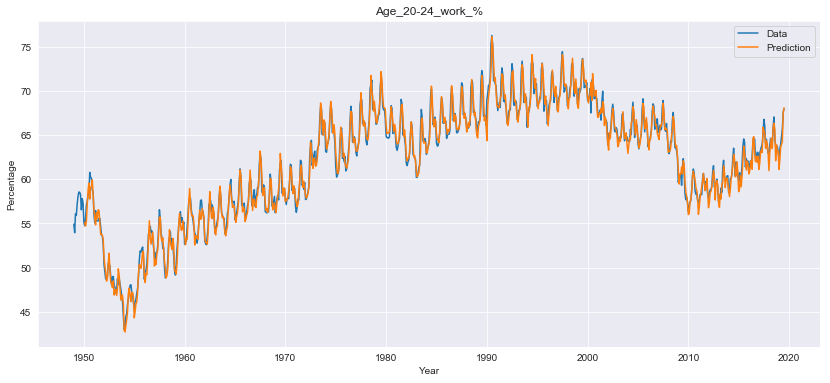

<Figure size 432x288 with 0 Axes>

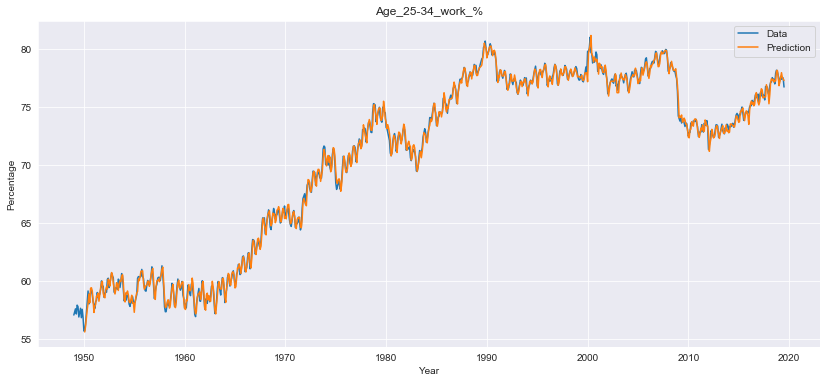

<Figure size 432x288 with 0 Axes>

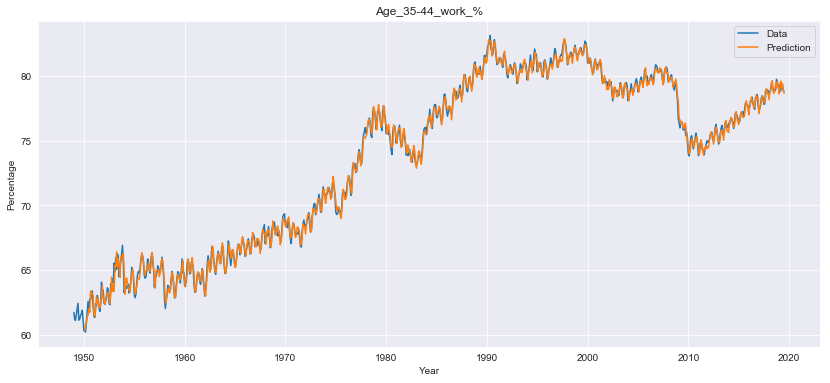

<Figure size 432x288 with 0 Axes>

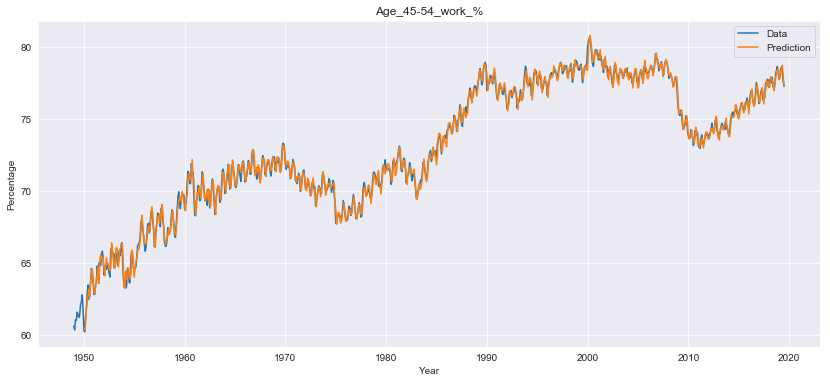

<Figure size 432x288 with 0 Axes>

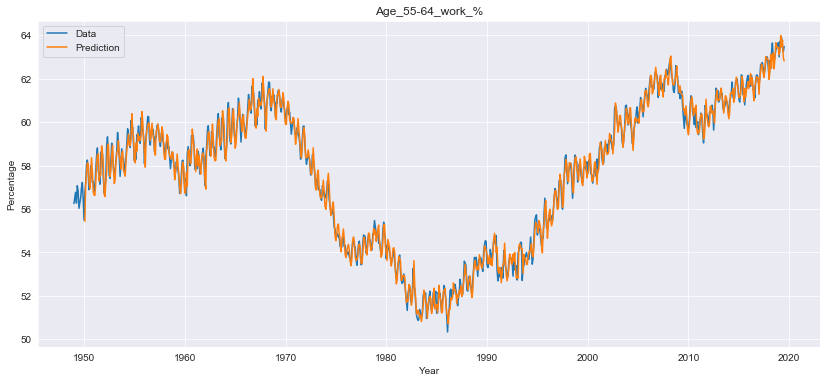

<Figure size 432x288 with 0 Axes>

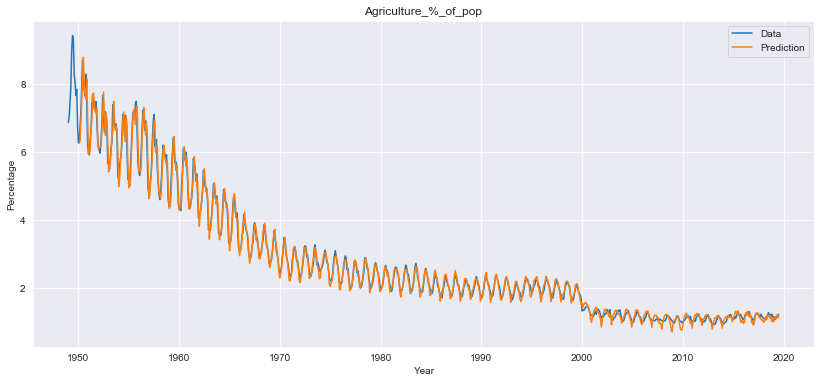

<Figure size 432x288 with 0 Axes>

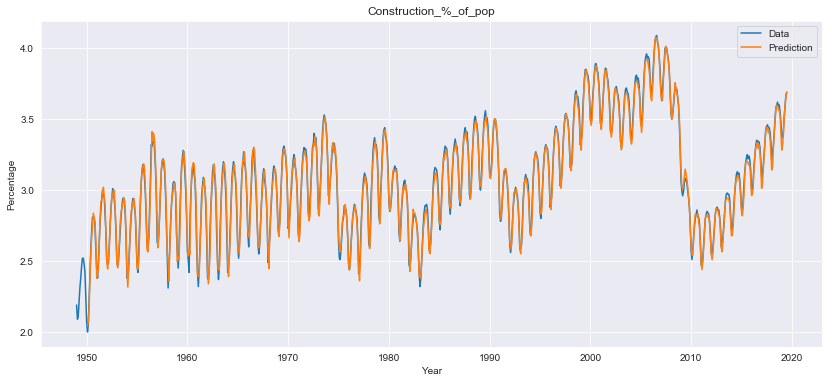

<Figure size 432x288 with 0 Axes>

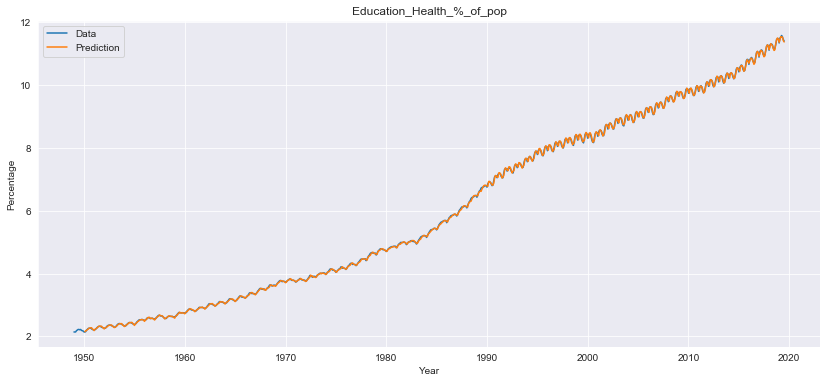

<Figure size 432x288 with 0 Axes>

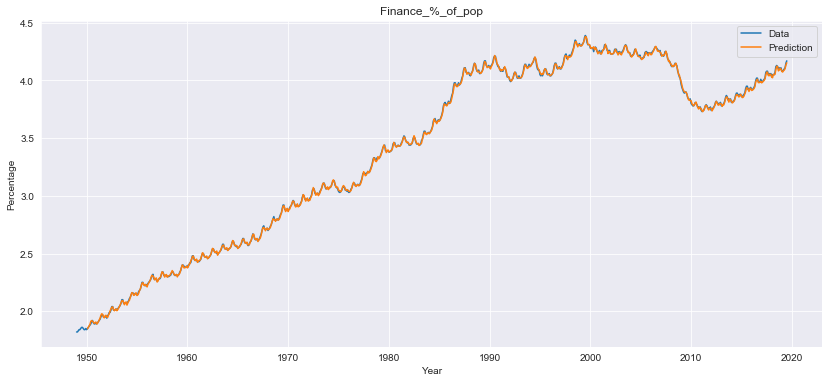

<Figure size 432x288 with 0 Axes>

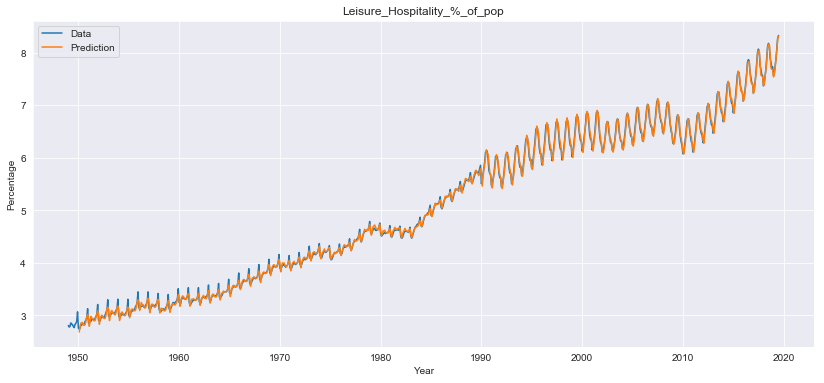

<Figure size 432x288 with 0 Axes>

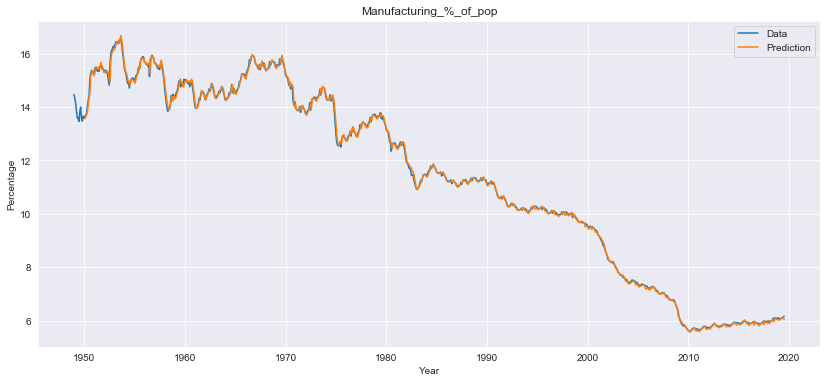

<Figure size 432x288 with 0 Axes>

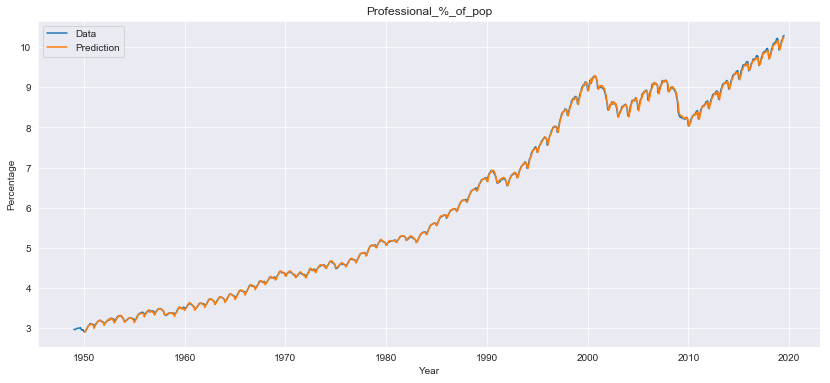

<Figure size 432x288 with 0 Axes>

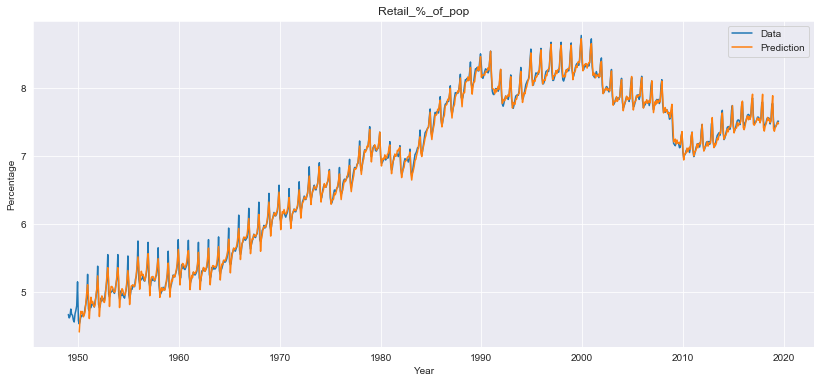

<Figure size 432x288 with 0 Axes>

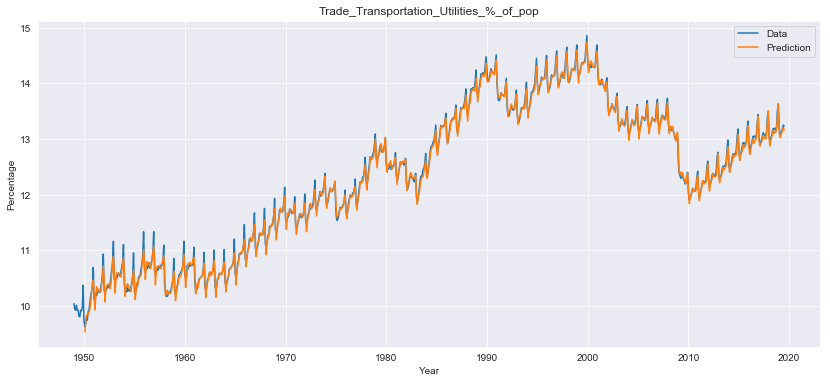

<Figure size 432x288 with 0 Axes>

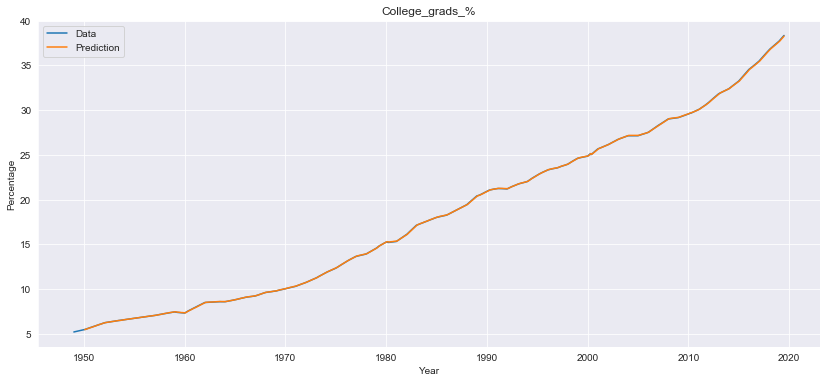

<Figure size 432x288 with 0 Axes>

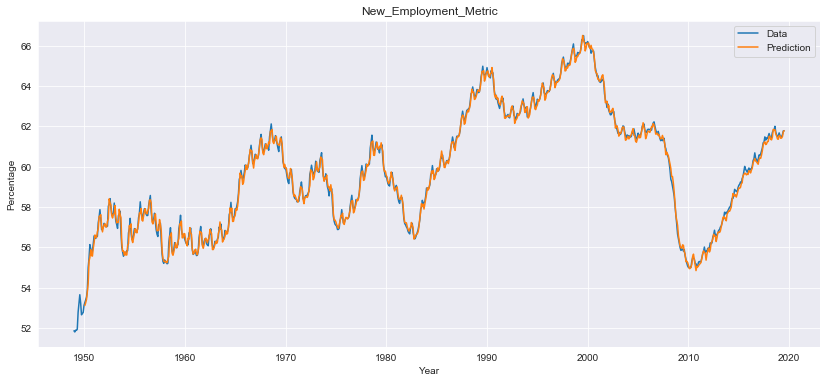

<Figure size 432x288 with 0 Axes>

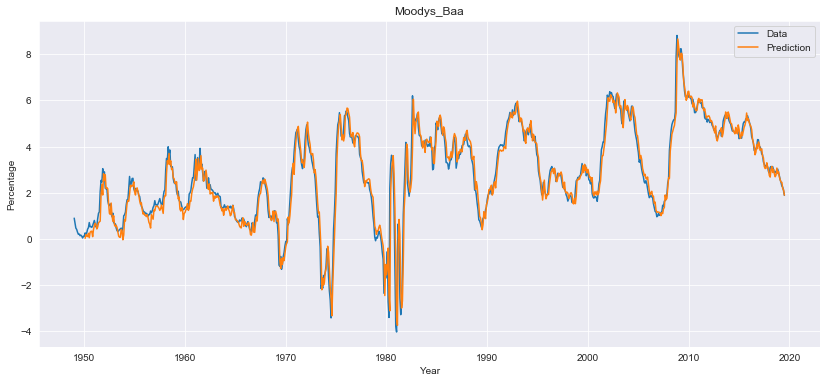

<Figure size 432x288 with 0 Axes>

In [981]:
for col in lstm_df.columns:
    plt.figure(figsize=(14,6))
    plt.plot(model_df[col], label='Data')
    plt.plot(predict_df[col], label='Prediction')
    plt.title(col)
    plt.legend()
    plt.ylabel('Percentage')
    plt.xlabel('Year')
    plt.show()
    plt.clf()

# Working Zone

In [6]:
age_1947_pop_df = pd.DataFrame()
for year in range(1947, 1980):
    temp_df = pd.read_excel('US_pop/pop_1948-1979/US Pop {}.xls'.format(str(year)), skiprows=8).iloc[:86, 1:2]
    temp_df.columns = ['Pop']
    temp_df['Age_16-19_pop'] = temp_df.iloc[16:20].Pop.sum()
    temp_df['Age_20-24_pop'] = temp_df.iloc[20:25].Pop.sum()
    temp_df['Age_25-34_pop'] = temp_df.iloc[25:35].Pop.sum()
    temp_df['Age_35-44_pop'] = temp_df.iloc[35:45].Pop.sum()
    temp_df['Age_45-54_pop'] = temp_df.iloc[45:55].Pop.sum()
    temp_df['Age_55-64_pop'] = temp_df.iloc[55:65].Pop.sum()
    temp_df = temp_df.drop('Pop', axis=1).iloc[:12]
    datelist = pd.date_range(pd.datetime(year,4,1), periods=12, freq='MS')
    temp_df.set_index(datelist, inplace=True)
    age_1947_pop_df = pd.concat([age_1947_pop_df, temp_df])

age_1947_popgroup_df = age_1947_pop_df.astype('int64')
display(age_1947_popgroup_df.info())
display(age_1947_popgroup_df.head())
display(age_1947_popgroup_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396 entries, 1947-04-01 to 1980-03-01
Data columns (total 6 columns):
Age_16-19_pop    396 non-null int64
Age_20-24_pop    396 non-null int64
Age_25-34_pop    396 non-null int64
Age_35-44_pop    396 non-null int64
Age_45-54_pop    396 non-null int64
Age_55-64_pop    396 non-null int64
dtypes: int64(6)
memory usage: 21.7 KB


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
1947-04-01,9096939,11814354,23235875,20421307,16970667,12527372
1947-05-01,9096939,11814354,23235875,20421307,16970667,12527372
1947-06-01,9096939,11814354,23235875,20421307,16970667,12527372
1947-07-01,9096939,11814354,23235875,20421307,16970667,12527372
1947-08-01,9096939,11814354,23235875,20421307,16970667,12527372


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
1979-11-01,17447096,20933574,35087548,24406493,23119836,20958964
1979-12-01,17447096,20933574,35087548,24406493,23119836,20958964
1980-01-01,17447096,20933574,35087548,24406493,23119836,20958964
1980-02-01,17447096,20933574,35087548,24406493,23119836,20958964
1980-03-01,17447096,20933574,35087548,24406493,23119836,20958964


In [10]:
age_1980_popgroup_df = pd.DataFrame()
for year in range(1980, 1990):
    datelist = pd.date_range(pd.datetime(year,4,1), periods=12, freq='MS')
    array_16 = np.zeros(12, dtype=int) + age_1980_popsumed_df[age_1980_popsumed_df.index.year == year]['Age_16-19_pop'][0]
    array_20 = np.zeros(12, dtype=int) + age_1980_popsumed_df[age_1980_popsumed_df.index.year == year]['Age_20-24_pop'][0]
    array_25 = np.zeros(12, dtype=int) + age_1980_popsumed_df[age_1980_popsumed_df.index.year == year]['Age_25-34_pop'][0]
    array_35 = np.zeros(12, dtype=int) + age_1980_popsumed_df[age_1980_popsumed_df.index.year == year]['Age_35-44_pop'][0]
    array_45 = np.zeros(12, dtype=int) + age_1980_popsumed_df[age_1980_popsumed_df.index.year == year]['Age_45-54_pop'][0]
    array_55 = np.zeros(12, dtype=int) + age_1980_popsumed_df[age_1980_popsumed_df.index.year == year]['Age_55-64_pop'][0]

    temp_df = pd.DataFrame(data={'Age_16-19_pop': array_16, 
                                 'Age_20-24_pop': array_20, 
                                 'Age_25-34_pop': array_25, 
                                 'Age_35-44_pop': array_35, 
                                 'Age_45-54_pop': array_45, 
                                 'Age_55-64_pop': array_55}, 
                           index=datelist)

    age_1980_popgroup_df = pd.concat([age_1980_popgroup_df, temp_df])

display(age_1980_popgroup_df.info())
display(age_1980_popgroup_df.head())
display(age_1980_popgroup_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 1980-04-01 to 1990-03-01
Data columns (total 6 columns):
Age_16-19_pop    120 non-null int64
Age_20-24_pop    120 non-null int64
Age_25-34_pop    120 non-null int64
Age_35-44_pop    120 non-null int64
Age_45-54_pop    120 non-null int64
Age_55-64_pop    120 non-null int64
dtypes: int64(6)
memory usage: 6.6 KB


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
1980-04-01,17447096,21385927,37429790,25806745,22743788,21753890
1980-05-01,17447096,21385927,37429790,25806745,22743788,21753890
1980-06-01,17447096,21385927,37429790,25806745,22743788,21753890
1980-07-01,17447096,21385927,37429790,25806745,22743788,21753890
1980-08-01,17447096,21385927,37429790,25806745,22743788,21753890


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
1989-11-01,14986194,19257793,43236300,36414619,24632992,21241075
1989-12-01,14986194,19257793,43236300,36414619,24632992,21241075
1990-01-01,14986194,19257793,43236300,36414619,24632992,21241075
1990-02-01,14986194,19257793,43236300,36414619,24632992,21241075
1990-03-01,14986194,19257793,43236300,36414619,24632992,21241075


In [17]:
age_2000_popgroup_df = pd.DataFrame()
for year in range(2000, 2010):
    datelist = pd.date_range(pd.datetime(year,5,1), periods=12, freq='MS')
    array_16 = np.zeros(12, dtype=int) + age_2000_pop_df[age_2000_pop_df.index.year == year]['Age_16-19_pop'][0]
    array_20 = np.zeros(12, dtype=int) + age_2000_pop_df[age_2000_pop_df.index.year == year]['Age_20-24_pop'][0]
    array_25 = np.zeros(12, dtype=int) + age_2000_pop_df[age_2000_pop_df.index.year == year]['Age_25-34_pop'][0]
    array_35 = np.zeros(12, dtype=int) + age_2000_pop_df[age_2000_pop_df.index.year == year]['Age_35-44_pop'][0]
    array_45 = np.zeros(12, dtype=int) + age_2000_pop_df[age_2000_pop_df.index.year == year]['Age_45-54_pop'][0]
    array_55 = np.zeros(12, dtype=int) + age_2000_pop_df[age_2000_pop_df.index.year == year]['Age_55-64_pop'][0]

    temp_df = pd.DataFrame(data={'Age_16-19_pop': array_16, 
                                 'Age_20-24_pop': array_20, 
                                 'Age_25-34_pop': array_25, 
                                 'Age_35-44_pop': array_35, 
                                 'Age_45-54_pop': array_45, 
                                 'Age_55-64_pop': array_55}, 
                           index=datelist)

    age_2000_popgroup_df = pd.concat([age_2000_popgroup_df, temp_df])

display(age_2000_popgroup_df.info())
display(age_2000_popgroup_df.head())
display(age_2000_popgroup_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2000-05-01 to 2010-04-01
Data columns (total 6 columns):
Age_16-19_pop    120 non-null int64
Age_20-24_pop    120 non-null int64
Age_25-34_pop    120 non-null int64
Age_35-44_pop    120 non-null int64
Age_45-54_pop    120 non-null int64
Age_55-64_pop    120 non-null int64
dtypes: int64(6)
memory usage: 6.6 KB


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
2000-05-01,16152324,19116667,39804497,45168843,37998974,24429066
2000-06-01,16152324,19116667,39804497,45168843,37998974,24429066
2000-07-01,16152324,19116667,39804497,45168843,37998974,24429066
2000-08-01,16152324,19116667,39804497,45168843,37998974,24429066
2000-09-01,16152324,19116667,39804497,45168843,37998974,24429066


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
2009-12-01,17662787,21384122,40723342,41487811,44867088,35405600
2010-01-01,17662787,21384122,40723342,41487811,44867088,35405600
2010-02-01,17662787,21384122,40723342,41487811,44867088,35405600
2010-03-01,17662787,21384122,40723342,41487811,44867088,35405600
2010-04-01,17662787,21384122,40723342,41487811,44867088,35405600


In [21]:
ssa_df = pd.read_csv('Season_no/Employees - Yearly Disability.csv').iloc[:, :2]
ssa_df['Total'] = ssa_df['Total'].apply(lambda x: int(x.replace(',', '')))

ssa_timeseries_df = pd.DataFrame()
for year in range(1960, 2017):
    datelist = pd.date_range(pd.datetime(year,1,1), periods=12, freq='MS')
    ssa_array = np.zeros(12, dtype=int) + ssa_df[ssa_df.Year == year]['Total'].values[0]


    temp_df = pd.DataFrame(data={'SSA_disab': ssa_array}, index=datelist)

    ssa_timeseries_df = pd.concat([ssa_timeseries_df, temp_df])

display(ssa_timeseries_df.info())
display(ssa_timeseries_df.head())
display(ssa_timeseries_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 684 entries, 1960-01-01 to 2016-12-01
Data columns (total 1 columns):
SSA_disab    684 non-null int64
dtypes: int64(1)
memory usage: 10.7 KB


None

,SSA_disab
1960-01-01,559425
1960-02-01,559425
1960-03-01,559425
1960-04-01,559425
1960-05-01,559425


,SSA_disab
2016-08-01,10153205
2016-09-01,10153205
2016-10-01,10153205
2016-11-01,10153205
2016-12-01,10153205


In [335]:
test_df = full_df[['Age_16-19_emp',
                   'Age_20-24_emp',
                   'Age_25-34_emp',
                   'Age_35-44_emp',
                   'Age_45-54_emp',
                   'Age_55-64_emp',
                   'Full_and_part_time']]
test_df['Full_employed'] = (test_df['Age_16-19_emp'] + \
                            test_df['Age_20-24_emp'] + \
                            test_df['Age_25-34_emp'] + \
                            test_df['Age_35-44_emp'] + \
                            test_df['Age_45-54_emp'] + \
                            test_df['Age_55-64_emp']
                           )
test_df.astype('int64').tail()

,Age_16-19_emp,Age_20-24_emp,Age_25-34_emp,Age_35-44_emp,Age_45-54_emp,Age_55-64_emp,Full_and_part_time,Full_employed
2019-03-01,4887000,13925000,35686000,32785000,32279000,26933573,153133000,146495573
2019-04-01,4672000,14114000,35602000,33001000,32287000,27126621,153133000,146802621
2019-05-01,4888000,14288000,35703000,33080000,32150000,26942108,153133000,147051108
2019-06-01,5941000,14699000,35699000,32933000,31816000,26877195,153133000,147965195
2019-07-01,6409000,14787000,35369000,32904000,31638000,26992031,153133000,148099031


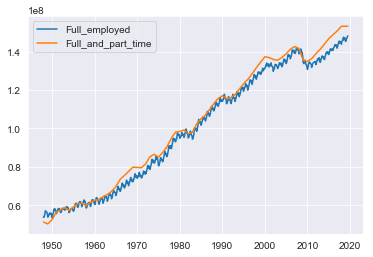

In [336]:
plt.plot(test_df['Full_employed'])
plt.plot(test_df['Full_and_part_time'])
plt.legend()

In [399]:
ssa_hard_values = full_df['SSA_disab'].dropna()
# cutoff = int(round(len(ssa_hard_values) * .8, 0))
train= ssa_hard_values[ssa_hard_values.index.year < 2016-12]
test = ssa_hard_values[ssa_hard_values.index.year >= 2016-12]
stepwise_model = pm.auto_arima(ssa_hard_values, start_p=0, start_q=0,
                             max_p=12, max_q=12,
                             seasonal=False,
                             start_d=0, max_d=12, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)
display(stepwise_model.summary())

Fit ARIMA: order=(0, 2, 0); AIC=21111.381, BIC=21120.817, Fit time=0.008 seconds
Fit ARIMA: order=(1, 2, 0); AIC=20875.755, BIC=20889.909, Fit time=0.022 seconds
Fit ARIMA: order=(0, 2, 1); AIC=20504.544, BIC=20518.698, Fit time=0.087 seconds
Fit ARIMA: order=(1, 2, 1); AIC=20504.357, BIC=20523.228, Fit time=0.262 seconds
Fit ARIMA: order=(1, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 2, 2); AIC=20443.865, BIC=20472.171, Fit time=0.422 seconds
Fit ARIMA: order=(3, 2, 2); AIC=20475.118, BIC=20508.143, Fit time=0.837 seconds
Fit ARIMA: order=(2, 2, 1); AIC=20503.909, BIC=20527.498, Fit time=0.387 seconds
Fit ARIMA: order=(2, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 2, 3); AIC=20415.553, BIC=20453.295, Fit time=0.775 seconds
Fit ARIMA: order=(4, 2, 3); AIC=20415.249, BIC=20457.710, Fit time=0.944 seconds
Fit ARIMA: order=(4, 2, 2); AIC=20427.240, BIC=20464.983, Fit time=0.678 seconds
Fit ARIMA: order=(4, 2, 4); AIC=20394.489, BIC=20441.667

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                  827
Model:                 ARIMA(6, 2, 4)   Log Likelihood              -10165.037
Method:                       css-mle   S.D. of innovations          52529.827
Date:                Thu, 05 Sep 2019   AIC                          20354.074
Time:                        15:46:23   BIC                          20410.687
Sample:                             2   HQIC                         20375.788
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.6200     88.608     -0.075      0.940    -180.288     167.048
ar.L1.D2.y    -0.7412      0.046    -16.245      0.000      -0.831      -0.652
ar.L2.D2.y     0.0888      0.055      1.626      0.104      -0.018       0.196
ar.L3.D2.y     0.4400      0.048      9.104      0.000       0.345       0.535
ar.L4.D2.y    -0.1825      0.046     -3.945      0.000      -0.273      -0.092
ar.L5.D2.y    -0.2286      0.048     -4.755      0.000      -0.323      -0.134
ar.L6.D2.y    -0.2686      0.037     -7.207      0.000      -0.342      -0.196
ma.L1.D2.y    -0.3424      0.037     -9.171      0.000      -0.416      -0.269
ma.L2.D2.y    -0.9612      0.054    -17.686      0.000      -1.068      -0.855
ma.L3.D2.y    -0.3762      0.033    -11.565      0.000      -0.440      -0.312
ma.L4.D2.y     0.7711      0.026     29.775      0.000       0.720       0.822
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0529           -0.6415j            1.2329           -0.0871
AR.2            1.0529           +0.6415j            1.2329            0.0871
AR.3           -0.8971           -0.5682j            1.0619           -0.4101
AR.4           -0.8971           +0.5682j            1.0619            0.4101
AR.5           -0.5812           -1.3543j            1.4737           -0.3145
AR.6           -0.5812           +1.3543j            1.4737            0.3145
MA.1           -0.8247           -0.6555j            1.0534           -0.3931
MA.2           -0.8247           +0.6555j            1.0534            0.3931
MA.3            1.0686           -0.1636j            1.0811           -0.0242
MA.4            1.0686           +0.1636j            1.0811            0.0242
-----------------------------------------------------------------------------
"""

In [400]:
stepwise_model.fit(train)
yhat = stepwise_model.predict(n_periods=13*12+1)

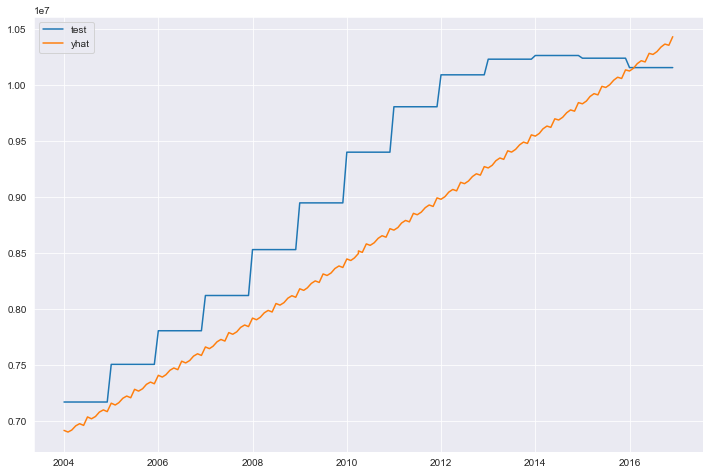

In [401]:
yhat_series = pd.Series(index=test.index, data=yhat)
plt.figure(figsize=(12,8))
plt.plot(test, label='test')
plt.plot(yhat_series, label='yhat')
plt.legend()

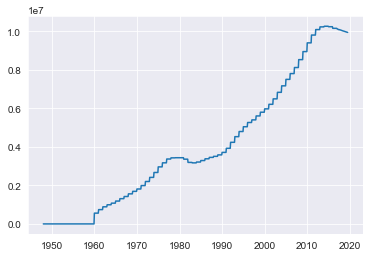

In [402]:
stepwise_model.fit(ssa_hard_values)
yhat_2 = stepwise_model.predict(n_periods=31)
yhat_2_series = pd.Series(index=full_df.index[full_df['SSA_disab'].isna()], data=yhat_2)

arima_ssa = ssa_hard_values.append(yhat_2_series)
plt.plot(arima_ssa)

In [110]:
# lstm_model = add_model_lags(model_df.applymap(lambda x: x/100), n_in=steps_to_predict, n_out=steps_to_predict-1)
# display(lstm_model.info())
# display(lstm_model['College_grads_%(t+11)'].head())
# display(lstm_model['College_grads_%(t+11)'].tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 836 entries, 1949-01-01 to 2018-08-01
Freq: MS
Columns: 432 entries, Age_16-19_work_%(t-1) to New_Employment_Metric(t+11)
dtypes: float64(432)
memory usage: 2.8 MB


None

1949-01-01    0.054425
1949-02-01    0.054624
1949-03-01    0.054944
1949-04-01    0.055268
1949-05-01    0.055587
Freq: MS, Name: College_grads_%(t+11), dtype: float64

2018-04-01    0.379183
2018-05-01    0.380253
2018-06-01    0.381319
2018-07-01    0.382374
2018-08-01    0.383411
Freq: MS, Name: College_grads_%(t+11), dtype: float64

In [66]:
def add_model_lags(df, n_in=1, n_out=1):
    prior_df = df.drop(df.columns[:-1], axis=1)
    for col in df.columns:
        for lag in range(1, n_in+1):
            prior_df[col+'(t-{})'.format(str(lag))] = df[col].shift(lag)
        for lag in range(1, n_out+1):
            df[col+'(t+{})'.format(str(lag))] = df[col].shift(-lag)            
    new_df = prior_df.drop(prior_df.columns[0], axis=1).join(df)
    return new_df.dropna()

In [301]:
create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models